# Setup

In [1]:
############################################################################################################################ 
# Get the latest CREST files for each ID within the target folder (dirname)

from pathlib import Path
import json
from sqlite3 import connect as sqlite3_connect
from sqlite3 import DatabaseError
from igraph import Graph as ig_Graph
from igraph import plot as ig_plot
from scipy.spatial.distance import cdist
from random import choice as random_choice
from itertools import combinations
from numpy import array, unravel_index, argmin, mean
import random
import numpy as np
from copy import deepcopy
import itertools
from datetime import datetime
from time import time
import neuroglancer
from webbrowser import open as wb_open
from webbrowser import open_new as wb_open_new
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm

# from eCREST_cli_beta import ecrest, import_settings
from eCREST_cli import ecrest, import_settings, get_cell_filepaths

The 'ecrest' class has been imported from eCREST_cli.py

An instance of this object will be able to:
- open an neuroglancer viewer for proofrieading (see "Proofread using CREST")
    - add-remove segments (using graph feature for efficiency)
    - format itself and save itself as a CREST-style .json
- convert from neuroglancer json (see "Convert From Neuroglancer to eCREST")
    - format itself and save itself as a CREST-style .json
    


## Import settings

If you save a copy of settings_dict.json (found in the "under construction" directory of eCREST repo) locally somewhere outside the repo (like in your save_dir), then you can use the following code cell to import. This avoids needing to re-type the save_dir and db_path each time you "git pull" updates from the repo to this notebook.

In [11]:
path_to_settings_json = '/Users/kperks/Documents/ell-connectome/eCREST-local-files/settings_dict.json'
settings_dict = import_settings(path_to_settings_json)

## Load files

In [413]:
dirpath = Path(settings_dict['save_dir'])
# dirpath = "/Users/kperks/Documents/gdrive/.shortcut-targets-by-id/16q1BuOMfD2ta0Cwq8CjMlRe4rDvbuWC5/ELL_connectome/CREST_reconstructions/mg-network"

In [414]:
nodefiles = get_cell_filepaths(dirpath)

# cell types

In [415]:
cell_type = {}
not_typed = []
for x,f in nodefiles.items():
    cell = ecrest(settings_dict,filepath = f,launch_viewer=False)
    cell_type[x] = cell.get_ctype('manual') 
    if (cell.get_ctype('manual') == []) | (cell.get_ctype('manual') == ''):
        cell_type[x]=''
        not_typed.append(x)# print(f'cell {x} is not cell-typed in json')
        
print('the following cells are not typed in the main network')
print(not_typed)        
        

the following cells are not typed in the main network
[]


# soma size

In [416]:
soma_diam = {}
for x,f in nodefiles.items():
    cell = ecrest(settings_dict,filepath = f,launch_viewer=False)
    if 'soma' in cell.cell_data['end_points'].keys():
        soma_anno = cell.cell_data['end_points']['soma']
        if len(soma_anno)==4:
            xpts = [p[0] for p in soma_anno]
            zpts = [p[2] for p in soma_anno]
            soma_diam[x] = np.mean([int((np.max(xpts)-np.min(xpts))/16),int((np.max(zpts)-np.min(zpts))/16)])/100
        if len(soma_anno)!=4:
            soma_diam[x] = np.NaN
    
    if 'soma' not in cell.cell_data['end_points'].keys():
        soma_diam[x] = np.NaN


In [718]:
apical_tip = {}
for x in nodes:
    cell = ecrest(settings_dict,filepath = nodefiles[x],launch_viewer=False)
    if 'apical-tip' in cell.cell_data['end_points'].keys():
        anno = cell.cell_data['end_points']['apical-tip']
        apical_tip[x] = len(anno)
    
    if 'apical-tip' not in cell.cell_data['end_points'].keys():
        apical_tip[x] = np.NaN

In [719]:
file_size = {}
for x in nodes:
    file_size[x] = nodefiles[x].stat().st_size
    

In [399]:
soma_size = {}
for x in nodefiles.keys():
    cell = ecrest(settings_dict,filepath = nodefiles[x],launch_viewer=False)
    all_segs = [a for b in cell.cell_data['base_segments'].values() for a in b]
    if len(cell.cell_data['base_segments']['unknown']) < len(all_segs):
        soma_size[x]=len(cell.cell_data['base_segments']['unknown'])
    if len(cell.cell_data['base_segments']['unknown']) == len(all_segs):
        soma_size[x]=np.NaN
        # print(f'structures not labeled for {cell.cell_data["metadata"]["main_seg"]["base"]}')



## visualization of sizes data

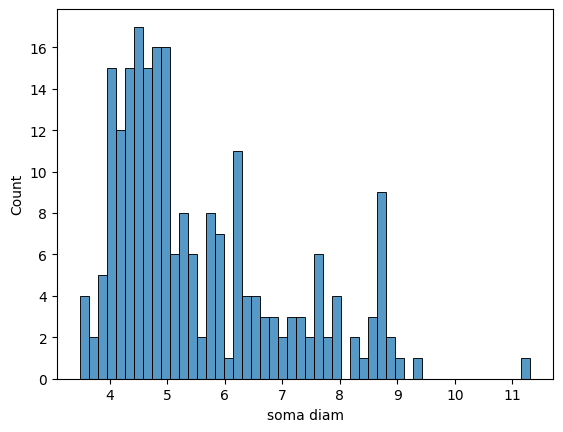

In [190]:
df = pd.DataFrame(soma_diam.items(), columns=['cell', 'soma diam']).set_index('cell')

for c in df.index:
    df.loc[c,'type'] = cell_type[c]
df = df[df['type'].isin(['mg1','mg2','sg1','sg2','sgx1','sgx2'])]
# df['binned'] = pd.cut(df['soma diam'], bins=np.arange(0,4000,200)).values
ax = sns.histplot(data = df,x='soma diam',bins = 50)#,hue='type')


<AxesSubplot:xlabel='soma diam', ylabel='Density'>

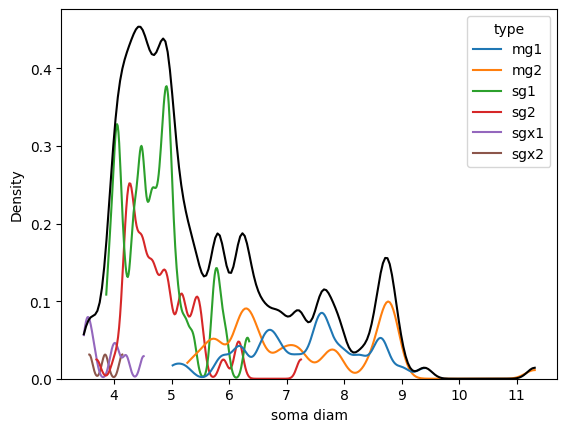

In [191]:
hfig,ax = plt.subplots(1)
sns.kdeplot(data = df[df['type'].isin(['mg1','mg2','sg1','sg2','sgx1','sgx2'])],x='soma diam',bw_adjust=0.25,cut=0,hue='type',ax=ax)
sns.kdeplot(data = df[df['type'].isin(['mg1','mg2','sg1','sg2','sgx1','sgx2'])],x='soma diam',bw_adjust=0.25,cut=0,color='black',ax=ax)

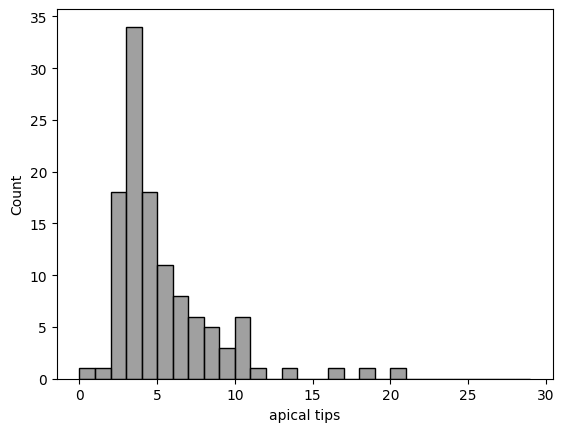

In [581]:
df = pd.DataFrame(apical_tip.items(), columns=['cell', 'apical tips']).set_index('cell')

for c in df.index:
    df.loc[c,'type'] = cell_type[c]

df = df[df['type'].isin(['mg1','mg2','sg1','sg2'])]

df['binned'] = pd.cut(df['apical tips'], bins=np.arange(0,4000,200)).values

ax = sns.histplot(data = df,x='apical tips',bins = np.arange(0,30,1),color='gray')
# sns.kdeplot(data = df[df['type'].isin(['mg1','mg2','sg1','sg2'])],x='soma size',bw_adjust=0.25,cut=0)

In [26]:
# df[(df['soma diam']>7) & (df['soma diam']<10)]

# Load graph dataframes and visualize

In [451]:
savepath = Path('/Users/kperks/Documents/gdrive/.shortcut-targets-by-id/16q1BuOMfD2ta0Cwq8CjMlRe4rDvbuWC5/ELL_connectome/CREST_reconstructions/mg-network/graphs/')

df_syn_pre = pd.read_csv(savepath / 'df_presyn.csv')
df_syn_post = pd.read_csv(savepath / 'df_postsyn.csv')

## Completeness of synapses

In [469]:
df_syn = df_syn_pre
syn = 'pre-synaptic'
all_types = set(df_syn['pre_type'].unique()) | set(df_syn['post_type'].unique()) - set(['glia'])
c_type_check = all_types #['mg1','mg2','sg1','sg2','grc']

df_progress = pd.DataFrame(columns = ['id','type','soma-diam','n','done','todo','ratio'])
for c in df_syn['pre'].unique():
    
    if (df_syn[df_syn['pre'] == c]['pre_type'].unique()[0] in c_type_check):

        c_df = df_syn[df_syn['pre'].isin([c])]

        cell = ecrest(settings_dict,filepath = nodefiles[str(c)],launch_viewer=False)

        cell_dict = {
            'id': cell.cell_data['metadata']['main_seg']['base'],
            'type': cell.get_ctype("manual"),
            'soma-diam': soma_diam[str(c)],
            'n_syn': len(cell.cell_data['end_points'][syn]),
            'done': len(c_df),
            'todo': len(cell.cell_data['end_points'][syn]) - len(c_df),
            'completed': len(c_df) / (len(cell.cell_data['end_points'][syn]))
            }

        df_progress = pd.concat([df_progress,pd.DataFrame([cell_dict])])

In [ ]:
# cells_todo = ['299496636','128832297','214581797','218095913','226019332','305051491','389812730','393325331'] # most complete examples
# cells_todo = ['223881844','226019332','228366816','481412554','482680782','483689146'] # grc-d with all labeled
# cells_todo = ['558238428','558189118','128708970','214627855','213699579','386470356'] # mg-like sg1
cells_todo = ['127672247','386409916','386488569','473336431','388914881','392411629'] # mg-like sg2

# df_progress = df_progress[df_progress['ratio']>0.9]
df_progress[df_progress['id'].isin(cells_todo)]#[df_progress['ratio']>0.95]
df_progress

In [443]:
pre_types = ['mg1','mg2']#['sg1','sg2','sgx1','sgx2']
# df_progress[(df_progress['type'].isin(pre_types))&(df_progress['ratio']>0.9)]#,'sg2'])]
df_progress[(df_progress['ratio']>0.9)]#,'sg2'])]

,id,type,soma-diam,n,done,todo,ratio
0,214581797,mg2,8.735,582,566,16,0.972509
0,226019332,grc-d,NaN,86,86,0,1.000000
0,299392199,mg1,6.715,84,84,0,1.000000
0,305051491,grc-s,NaN,51,47,4,0.921569
0,386392158,mg2,7.010,206,186,20,0.902913
0,389812730,grc-s,NaN,80,80,0,1.000000
0,392042360,grc-s,NaN,57,57,0,1.000000
0,403522169,grc-d,NaN,2,2,0,1.000000
0,565013265,grc-s,NaN,70,70,0,1.000000


In [79]:
# df_progress[df_progress['id'].isin(df[(df['soma diam']>4) & (df['soma diam']<5)].index)]

In [419]:
df_progress[df_progress['type']=='grc-s']#.id.values#.describe()

,id,type,soma-diam,n,done,todo,ratio
0,219161561,grc-s,NaN,90,14,76,0.155556
0,305051491,grc-s,NaN,51,47,4,0.921569
0,306242528,grc-s,NaN,47,29,18,0.617021
0,307621813,grc-s,NaN,48,5,43,0.104167
0,389812730,grc-s,NaN,80,80,0,1.000000
0,392042360,grc-s,NaN,57,57,0,1.000000
0,45120720,grc-s,NaN,25,2,23,0.080000
0,565013265,grc-s,NaN,70,70,0,1.000000


In [470]:
df_progress[df_progress['id'].isin(['305051491', '306242528', '389812730', '392042360', '565013265'])][['id','n','ratio']]#.id.values#.describe()

,id,n,ratio
0,305051491,51,0.921569
0,306242528,47,0.617021
0,389812730,80,1.000000
0,392042360,57,1.000000
0,565013265,70,1.000000


In [ ]:
['214613070','215883144','']

## Specific cell examples

In [437]:
df_syn

,Unnamed: 0,pre,post,structure,x,y,z,pre_type,post_type
0,0,128832297,126556393,unknown,17140,15880,767,sg1,uk
1,1,128832297,223864713,axon,17270,15938,758,sg1,grc-d
2,2,128832297,127702707,unknown,17316,15930,745,sg1,uk
3,3,128832297,127702527,unknown,17299,15969,735,sg1,uk
4,4,128832297,127701946,unknown,17229,15944,722,sg1,uk
...,...,...,...,...,...,...,...,...,...
2841,2841,565013265,567318720,unknown,15518,20059,2766,grc-s,uk
2842,2842,565013265,482512968,unknown,13487,20478,2610,grc-s,uk
2843,2843,565013265,568432342,axon,14645,18946,2829,grc-s,grc-d
2844,2844,565013265,399018592,axon,15819,19169,2623,grc-s,grc-d


In [440]:
focal_cell_id = 565013265 #214581797 #

df_syn = df_syn_pre
# print(f'soma has {soma_size[str(focal_cell_id)]} segments')

print(f'{len(df_syn[df_syn["pre"]==focal_cell_id])} synapses reconstructed')
display(df_syn[df_syn['pre']==focal_cell_id][['post','post_type']].value_counts().reset_index(
    name='weight')['post_type'].value_counts().reset_index(name='ncells'))

display(df_syn[df_syn['pre']==focal_cell_id][['post','post_type','structure']].value_counts().reset_index(name='weight'))

display(df_progress[df_progress['id']==str(focal_cell_id)])

70 synapses reconstructed


,index,ncells
0,grc-d,18
1,uk,18
2,fov,3
3,sg1,2
4,sgx1,1
5,grc-s,1


,post,post_type,structure,weight
0,568416219,grc-d,axon,8
1,481367906,uk,unknown,4
2,567287588,grc-d,axon,3
3,484864533,grc-d,axon,3
4,483736327,grc-d,axon,3
5,483704550,grc-d,axon,3
6,568418195,grc-d,axon,2
7,484864178,grc-d,axon,2
8,484849685,grc-d,axon,2
9,656567214,fov,unknown,2


,id,type,n,done,todo,ratio
0,565013265,grc-s,70,70,0,1.0


In [138]:
[str(i) for i in df_syn[df_syn['post_type']=='lx']['post'].unique()]

['132205966', '475581206', '644112836', '565696071', '131737545', '485096532']

## Create edges dataframe among most completed

In [455]:
df_result = df_progress#[df_progress['ratio']>=0.9]
display(df_result['type'].value_counts())

mg2      40
mg1      35
sg2      24
sg1      23
grc-d    16
grc-s     9
sgx1      7
dml       4
sgx2      2
uk        1
aff       1
Name: type, dtype: int64

In [456]:
df_syn = df_syn_post
df_edges=df_syn[['pre','post','structure','pre_type','post_type']].value_counts().reset_index(name='weight')
# df_edges=df_syn[['pre','post','pre_type','post_type']].value_counts().reset_index(name='weight')

In [457]:
for i,r in df_edges.iterrows():
    df_edges.loc[i,'pre_diam']=soma_diam[str(df_edges.loc[i,'pre'])]
    df_edges.loc[i,'post_diam']=soma_diam[str(df_edges.loc[i,'post'])]

df_edges.loc[:,'diam_diff'] = (df_edges['post_diam']-df_edges['pre_diam'])/df_edges['pre_diam']

In [458]:
# df_edges = df_edges[((df_edges['pre_diam']>4.5) & (df_edges['pre_diam']<5)) | ((df_edges['pre_diam']>7))]

In [459]:
# restrict to most completed synapses based on df_result above
df_edges = df_edges[df_edges['pre'].isin([int(v) for v in df_result.id.values])]


In [449]:
# display(df_edges[['pre','pre_type']].value_counts())
display(df_edges[['pre','pre_type']].value_counts().reset_index(
    name='weight')['pre_type'].value_counts().reset_index(name='ncells'))

,index,ncells
0,grc-s,4
1,mg2,2
2,grc-d,2
3,mg1,1


In [228]:
df_edges.groupby('pre_type')['pre_diam'].describe()[['25%','50%','75%']]

,25%,50%,75%
pre_type,,,
dml,NaN,NaN,NaN
grc-d,NaN,NaN,NaN
grc-s,NaN,NaN,NaN
mg1,6.710,8.245,8.595
mg2,6.915,7.870,8.735
sg1,4.290,4.755,4.985
sg2,4.515,4.665,5.140
sgx1,3.475,3.475,3.475
sgx2,3.570,3.570,3.570


In [53]:
df_edges.loc[df_edges['pre_type'].isin(['uk']),'pre_type']='sg2'

### connectivity matrix

post_type,aff,dml,fov,grc-d,grc-s,mg1,mg2,sg1,sg2,sgx1,sgx2,tsd,uk
pre_type,,,,,,,,,,,,,
grc-d,41.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0
grc-s,0.0,0.0,2.0,64.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,28.0
mg1,0.0,0.0,5.0,23.0,0.0,0.0,6.0,0.0,45.0,0.0,11.0,0.0,11.0
mg2,2.0,6.0,15.0,0.0,11.0,7.0,0.0,32.0,0.0,3.0,1.0,0.0,23.0


Text(50.722222222222214, 0.5, 'pre type')

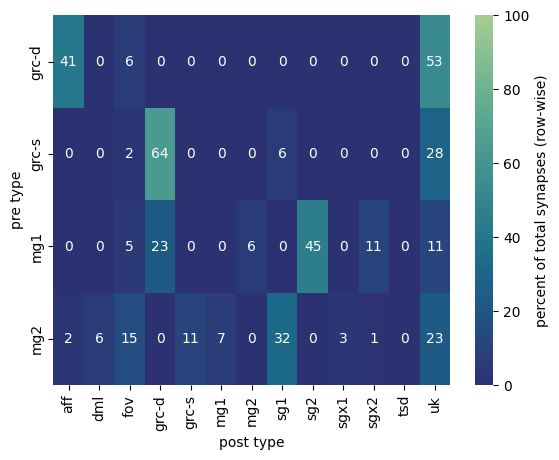

In [450]:
# network_types = ['mg1','mg2','lg','lf']
network_types = (set(df_edges['pre_type'].unique()) | set(df_edges['post_type'].unique())) - set(['glia'])#['mg1','mg2','sg1','sg2']#,'lg','lf','sgx','grc','aff']

res = df_edges[(df_edges['pre_type'].isin(network_types))&(df_edges['post_type'].isin(network_types))].groupby(
    ['pre_type','post_type'])[['weight']].sum(numeric_only=True)#.reset_index()

denom = res.groupby('pre_type')['weight'].sum()

res.weight = np.round(res.weight / denom *100)

# res.reset_index().pivot(index='pre_type', columns='post_type', values='weight').fillna(0)

display(res.reset_index().pivot(index='pre_type', columns='post_type', values='weight').fillna(0))

# hfig,ax = plt.subplots(1,figsize=(5,2))
ax = sns.heatmap(res.reset_index().pivot(index='pre_type', columns='post_type', values='weight').fillna(0),
            annot=True,cmap="crest_r",vmin=0,vmax=100,
           cbar_kws={'label': 'percent of total synapses (row-wise)'})

ax.set_xlabel('post type')
ax.set_ylabel('pre type')

In [431]:
df_edges[['pre','pre_type']].groupby(['pre_type']).count()
display(df_edges[['pre','pre_type']].value_counts().reset_index(
    name='weight')['pre_type'].value_counts().reset_index(name='ncells'))

df_edges[['post','post_type']].groupby(['post_type']).count()
display(df_edges[['post','post_type']].value_counts().reset_index(
    name='weight')['post_type'].value_counts().reset_index(name='ncells'))



,index,ncells
0,grc-s,5
1,grc-d,4
2,mg2,2
3,mg1,2
4,sg2,2
5,sg1,1
6,dml,1


,index,ncells
0,uk,374
1,grc-d,200
2,sg1,125
3,fov,106
4,sg2,49
5,dml,34
6,grc-s,33
7,sgx1,30
8,aff,23
9,mg2,20


### cell variability among most completed

In [432]:

def typed_progress_df(df_edges,pre_type):

    res = df_edges[df_edges['pre_type'].isin(pre_type)].groupby(
        ['pre','post_type'])[['weight']].sum(numeric_only=True)#.reset_index()
    denom = res.groupby('pre')['weight'].sum()

    res.weight = np.round(res.weight / denom *100)

    data = res.reset_index(level=[0,1]).fillna(0)
    
    return data

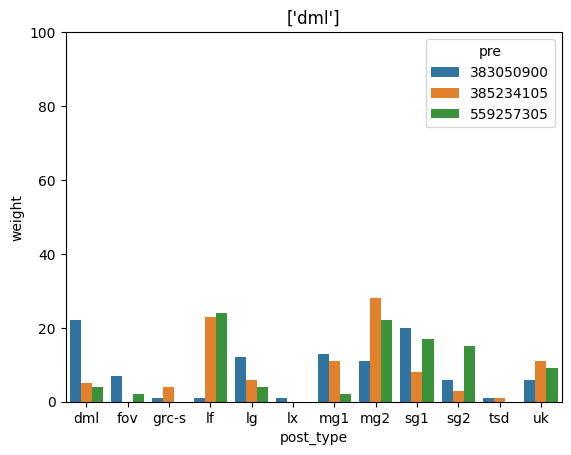

In [164]:
pre_type = ['dml']
data = typed_progress_df(df_edges,pre_type)
sns.barplot(data = data, y = 'weight', x = 'post_type', hue = 'pre',dodge=True)
plt.title(pre_type)
plt.ylim(0,100);

array([223881844, 226019332, 403522169, 481412554])

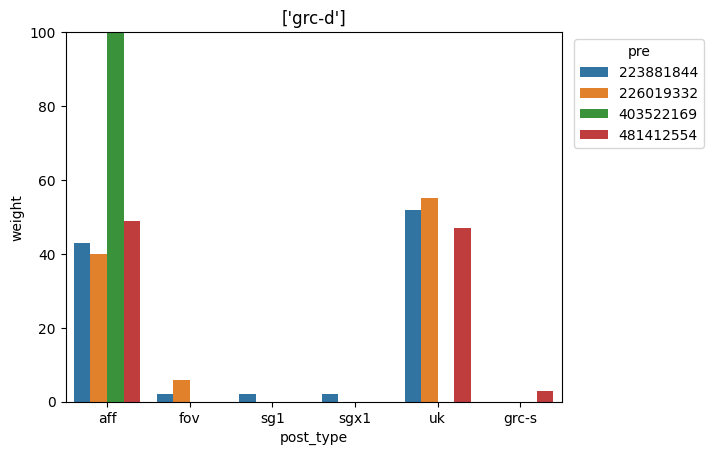

In [434]:
pre_type = ['grc-d']
data = typed_progress_df(df_edges,pre_type)
ax = sns.barplot(data = data, y = 'weight', x = 'post_type', hue = 'pre',dodge=True)
plt.title(pre_type)
plt.ylim(0,100);
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.3, 1))
data['pre'].unique()

array([305051491, 306242528, 389812730, 392042360, 565013265])

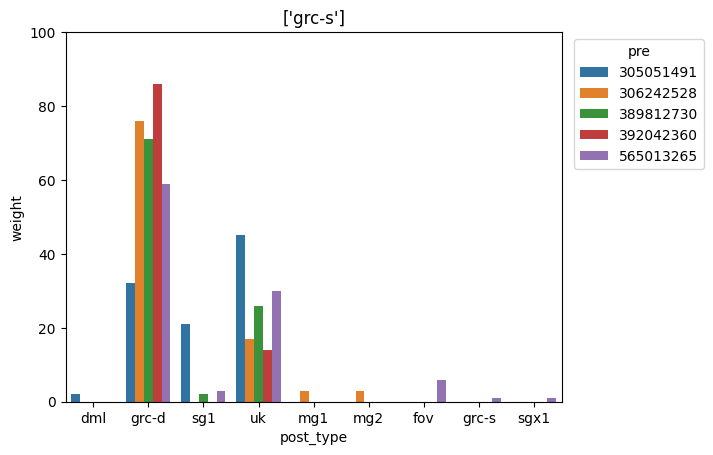

In [435]:
pre_type = ['grc-s']
data = typed_progress_df(df_edges,pre_type)
ax = sns.barplot(data = data, y = 'weight', x = 'post_type', hue = 'pre',dodge=True)
plt.title(pre_type)
plt.ylim(0,100);
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.3, 1))
data['pre'].unique()

array([305051491, 306242528, 389812730, 392042360, 565013265])

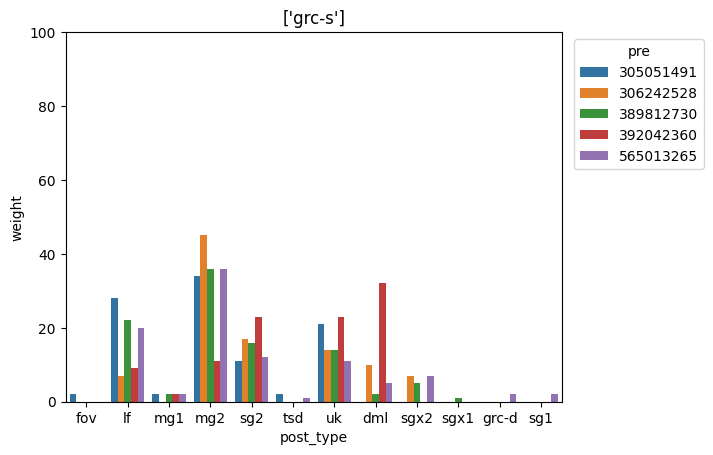

In [464]:
pre_type = ['grc-s']
data = typed_progress_df(df_edges[df_edges['pre'].isin([305051491, 306242528, 389812730, 392042360, 565013265])],pre_type)
ax = sns.barplot(data = data, y = 'weight', x = 'post_type', hue = 'pre',dodge=True)
plt.title(pre_type)
plt.ylim(0,100);
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.3, 1))
data['pre'].unique()

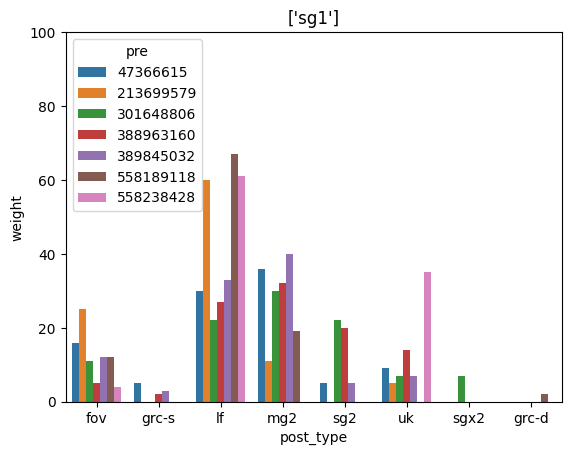

In [168]:
pre_type = ['sg1']
data = typed_progress_df(df_edges,pre_type)
ax = sns.barplot(data = data, y = 'weight', x = 'post_type', hue = 'pre',dodge=True)
plt.title(pre_type)
plt.ylim(0,100);

array([ 43622486, 128737253, 213669553, 299496636, 386224676, 472114046,
       473723476, 474111084])

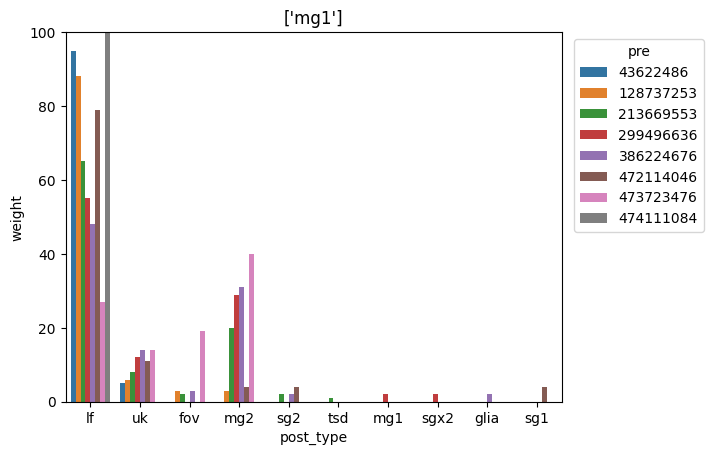

In [169]:
pre_type = ['mg1']
data = typed_progress_df(df_edges,pre_type)
ax = sns.barplot(data = data, y = 'weight', x = 'post_type', hue = 'pre',dodge=True)
plt.title(pre_type)
plt.ylim(0,100);
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.3, 1))
data['pre'].unique()

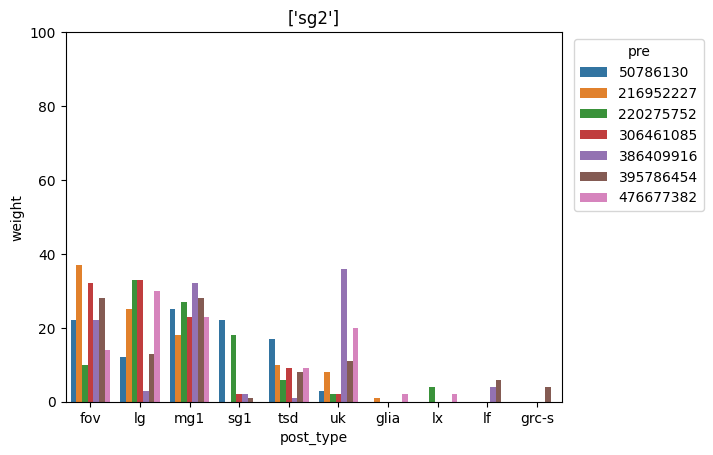

In [171]:
pre_type = ['sg2']
data = typed_progress_df(df_edges,pre_type)
ax = sns.barplot(data = data, y = 'weight', x = 'post_type', hue = 'pre',dodge=True)
plt.title(pre_type)
plt.ylim(0,100);
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.3, 1))

array([ 42800051, 128536704, 129619070, 130781211, 214581797, 300689181,
       386392158, 386426114, 387382792, 472284925])

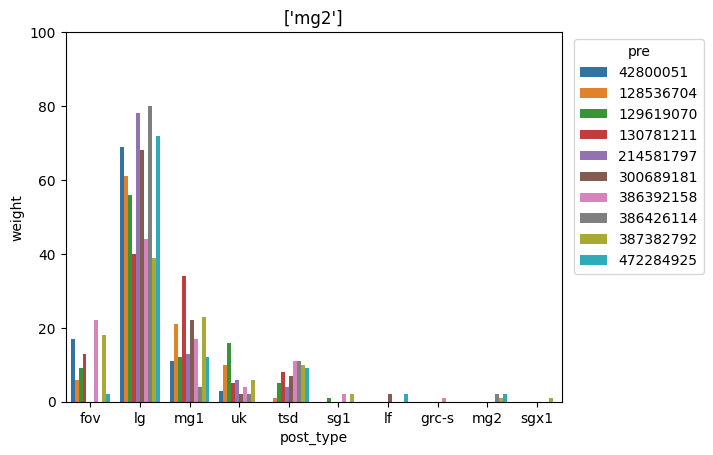

In [172]:
pre_type = ['mg2']
data = typed_progress_df(df_edges,pre_type)
ax = sns.barplot(data = data, y = 'weight', x = 'post_type', hue = 'pre',dodge=True)
plt.title(pre_type)
plt.ylim(0,100);
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.3, 1))
data['pre'].unique()

Text(0.5, 1.0, "['sgx1', 'sgx2']")

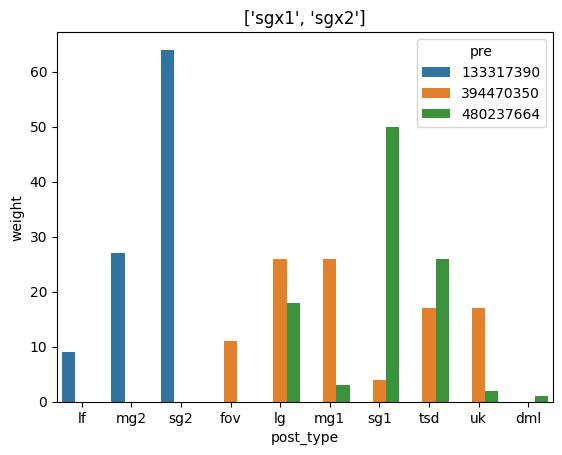

In [173]:
pre_type = ['sgx1','sgx2']
data = typed_progress_df(df_edges,pre_type)
sns.barplot(data = data, y = 'weight', x = 'post_type', hue = 'pre',dodge=True)
plt.title(pre_type)

# distributions of somas

In [193]:
# df_syn_post

In [254]:
path_to_settings_json = '/Users/kperks/Documents/ell-connectome/eCREST-local-files/settings_dict.json'
settings_dict = import_settings(path_to_settings_json)

dirpath = Path(settings_dict['save_dir'])

nodefiles = get_cell_filepaths(dirpath)


In [255]:
soma_diam = {}
soma_loc = {}
cell_type = {}
for x,f in nodefiles.items():
    cell = ecrest(settings_dict,filepath = f,launch_viewer=False)
    
    
    if 'soma' in cell.cell_data['end_points'].keys():
        soma_anno = cell.cell_data['end_points']['soma']
        xpts = [p[0] for p in soma_anno]
        ypts = [p[1] for p in soma_anno]
        zpts = [p[2] for p in soma_anno]

        soma_diam[x] = np.mean([int((np.max(xpts)-np.min(xpts))/16),int((np.max(zpts)-np.min(zpts))/16)])/100
        
        soma_loc[x] = [np.mean(xpts)/16,np.mean(ypts)/16,np.mean(zpts)/30]
        
        cell_type[x] = cell.get_ctype('manual') 

In [256]:
df_loc = pd.DataFrame(soma_loc).T
df_loc.columns=['x','y','z']

dict_list = [soma_diam, cell_type]

dfs = [pd.DataFrame(d.values()) for d in dict_list]

df_ = pd.concat(dfs, axis=1)

df_.columns = ['soma_diam','cell_type']
df_.index = soma_diam.keys()

df_soma = pd.concat([df_,df_loc],axis=1)

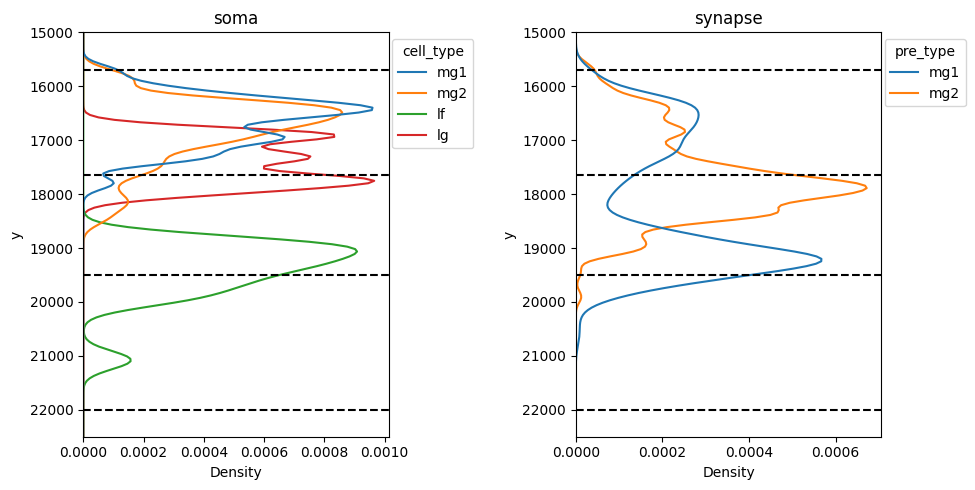

In [259]:
network_types = ['lg','lf','mg1','mg2']#,'sg1','sg2','sgx1','sgx2']#,'lf','lg']
# network_types = ['mg1','mg2']

hfig,ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

# sns.scatterplot(ax = ax[0],data=df_soma[df_soma['cell_type'].isin(network_types)],x='x',y='y',hue='cell_type',size='soma_diam',alpha = 0.75)
sns.kdeplot(ax = ax[0],data = df_soma[df_soma['cell_type'].isin(network_types)], 
            y = 'y', hue='cell_type',
           cut=0,clip=[23000,14000], common_norm=False, bw_adjust=0.5)#, cumulative=True)
for y_ in [22000, 19500, 17650, 15700]:
    ax[0].axhline(y=y_,color = 'black',linestyle='--')
ax[0].set_ylim(15000,22500)
ax[0].invert_yaxis()
sns.move_legend(ax[0], "upper right", bbox_to_anchor=(1.3, 1))
ax[0].set_title('soma')

network_types = ['mg1','mg2']#,'sg1','sg2','sgx1','sgx2']

sns.kdeplot(ax = ax[1],data = df_syn_post[(df_syn_post['pre_type'].isin(network_types))&(df_syn_post['post_type'].isin(network_types))], 
            y = 'y', hue='pre_type',
           cut=0,clip=[23000,14000], common_norm=False, bw_adjust=0.5)#, cumulative=True)for y_ in [22000, 19500, 17650, 15700]:
for y_ in [22000, 19500, 17650, 15700]:
    ax[1].axhline(y=y_,color = 'black',linestyle='--')
sns.move_legend(ax[1], "upper right", bbox_to_anchor=(1.3, 1))
ax[1].set_ylim(15000,22500)
ax[1].invert_yaxis()
ax[1].set_title('synapse')

hfig.tight_layout()

BUT **ARE** the sgx synapses actually onto each other's somas?... they seem to mostly synapse on sg1 and sg2 not each other?

# distributions of synapses

In [193]:
# df_syn_post

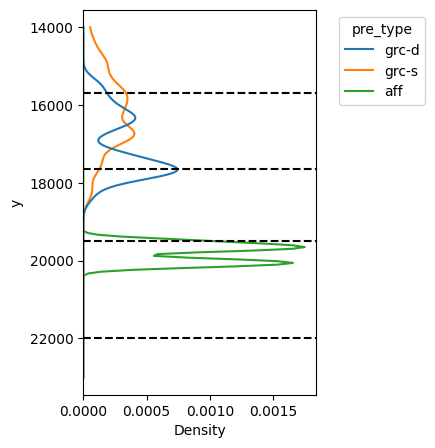

In [331]:
network_types = ['grc-d','grc-s','aff']#['mg1','mg2','sg1','sg2','sgx1','sgx2']#,,'aff','dml']
# network_types = ['mg1','mg2']
hfig,ax = plt.subplots(1,figsize=(3,5))
sns.kdeplot(data = df_syn_post[(df_syn_post['pre_type'].isin(network_types))&(df_syn_post['post_type'].isin(['mg1','mg2']))], 
            y = 'y', hue='pre_type',
           cut=0,clip=[23000,14000], common_norm=False, bw_adjust=0.5)#, cumulative=True)

ax.invert_yaxis()
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.5, 1))

for y_ in [22000, 19500, 17650, 15700]:
    ax.axhline(y=y_,color = 'black',linestyle='--')

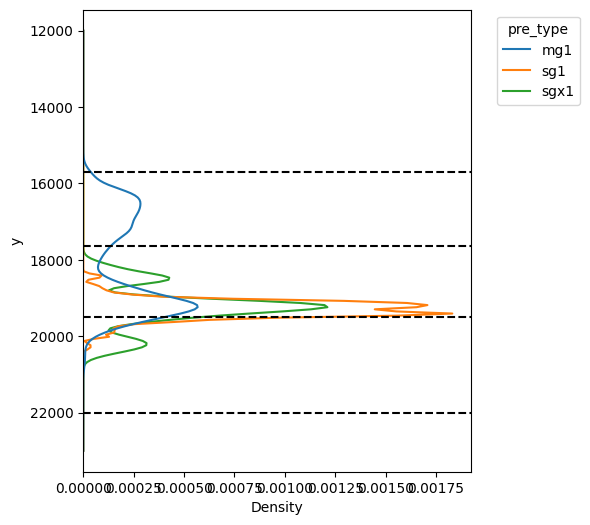

In [745]:
network_types = ['mg1','sg1','sgx1']#,'sg2','sgx1','sgx2']#,,'aff','dml']
# network_types = ['mg1','mg2']
hfig,ax = plt.subplots(1,figsize=(5,6))
ax = sns.kdeplot(data = df_syn_post[(df_syn_post['pre_type'].isin(network_types))&(df_syn_post['post_type'].isin(['mg1','mg2']))], 
            y = 'y', hue='pre_type',
           cut=0,clip=[23000,12000], common_norm=False, bw_adjust=0.5)#, cumulative=True)

ax.invert_yaxis()
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.3, 1))

for y_ in [22000, 19500, 17650, 15700]:
    ax.axhline(y=y_,color = 'black',linestyle='--')

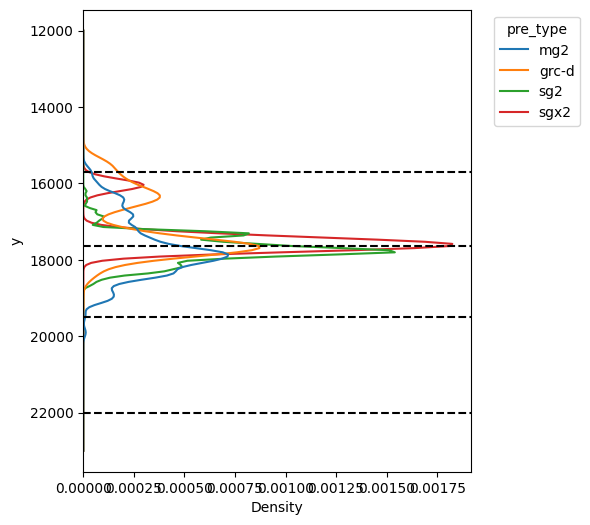

In [746]:
network_types = ['mg2','sg2','sgx2','grc-d']#,'sg2','sgx1','sgx2']#,,'aff','dml']
# network_types = ['mg1','mg2']
hfig,ax = plt.subplots(1,figsize=(5,6))
ax = sns.kdeplot(data = df_syn_post[(df_syn_post['pre_type'].isin(network_types))&(df_syn_post['post_type'].isin(['mg1','mg2']))], 
            y = 'y', hue='pre_type',
           cut=0,clip=[23000,12000], common_norm=False, bw_adjust=0.5)#, cumulative=True)

ax.invert_yaxis()
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.3, 1))

for y_ in [22000, 19500, 17650, 15700]:
    ax.axhline(y=y_,color = 'black',linestyle='--')

# sg vs mg synapses by soma size

In [174]:
network_types = ['mg1','mg2','sg1','sg2','sgx1','sgx2']

df_sub = df_syn_post[(df_syn_post['pre_type'].isin(network_types))&(df_syn_post['post_type'].isin(network_types))]

In [176]:
df_result = pd.DataFrame(columns = ['pre','pre_type','mg','sg','ssize'])

for k in df_sub['pre'].unique():
    # print(df_sub[df_sub['pre']==k])
    cell_df = df_sub[df_sub['pre']==k]
    if cell_df['pre_type'].isin(['sg1','mg1']).sum() > 0:
        w_sg = len(cell_df[cell_df['post_type']=='sg2'])
        w_mg = len(cell_df[cell_df['post_type']=='mg2'])
    if cell_df['pre_type'].isin(['sg2','mg2']).sum() > 0:
        w_sg = len(cell_df[cell_df['post_type']=='sg1'])
        w_mg = len(cell_df[cell_df['post_type']=='mg1'])
    
    cell_dict = {
        'pre': k,
        'pre_type': cell_df['pre_type'].unique()[0],
        'mg': w_mg,
        'sg': w_sg,
        'ssize': soma_diam[str(k)]
    }
    
    df_result = pd.concat([df_result,pd.DataFrame([cell_dict])])

In [177]:
df_result.groupby('pre_type').sum(numeric_only=True)

,ssize
pre_type,
mg1,118.110
mg2,185.640
sg1,64.865
sg2,67.000
sgx1,7.685
sgx2,7.715


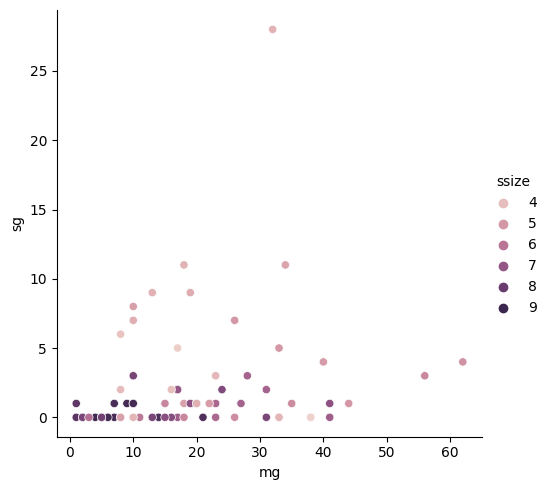

In [178]:
sns.relplot(data=df_result,y='sg',x='mg',hue='ssize')#,size='fsize')

In [179]:
df_result = df_sub[['pre','post','pre_type','post_type']].value_counts().reset_index(name='weight')

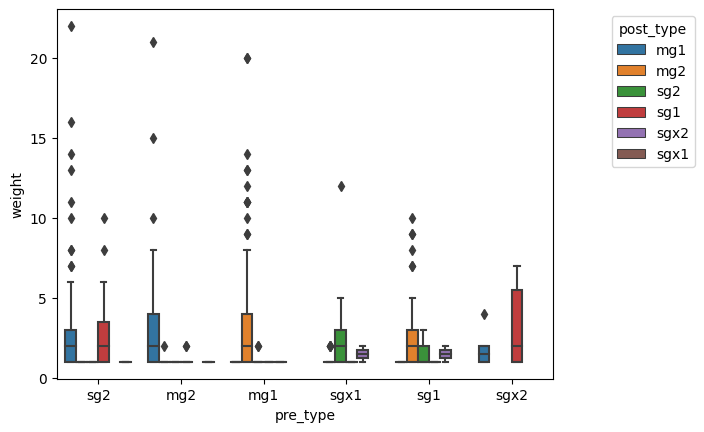

In [180]:
ax = sns.boxplot(data = df_result, x = 'pre_type',y='weight',hue='post_type')#,dodge=True,jitter=0.25)
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.3, 1))

# ax = sns.stripplot(data = df_result, x = 'pre_type',y='weight',hue='post_type',dodge=True,jitter=0.25,alpha=0.5)
# sns.move_legend(ax, "upper right", bbox_to_anchor=(1.3, 1))

In [181]:
df_result['pre_size'] = [soma_diam[str(k)] for k in df_result['pre']]

df_result['post_size'] = [soma_diam[str(k)] for k in df_result['post']]

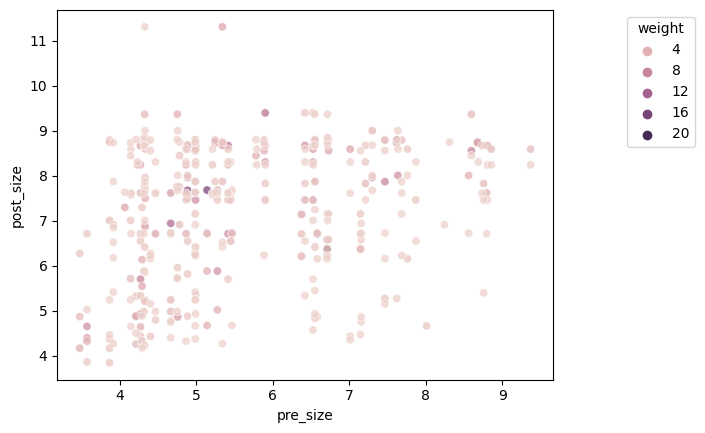

In [182]:
ax = sns.scatterplot(data = df_result,x='pre_size',y='post_size',hue = 'weight',alpha = 0.75)
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.3, 1))

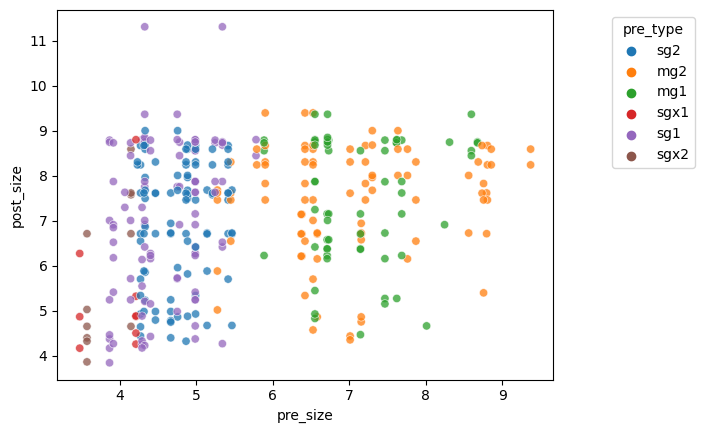

In [183]:
ax = sns.scatterplot(data = df_result,x='pre_size',y='post_size',hue = 'pre_type',alpha = 0.75)
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.3, 1))

# Edges dataframe

In [364]:
df_syn_post

,Unnamed: 0,pre,post,structure,x,y,z,pre_type,post_type
0,0,126618353,387850816,basal dendrite,23099,19611,1742,mg1,mg2
1,1,126618353,303212610,basal dendrite,23046,19674,1752,mg1,mg2
2,2,126618353,394686712,unknown,23132,19677,1754,mg1,lf
3,3,126618353,394686712,unknown,22487,19663,1713,mg1,lf
4,4,126618353,213605530,basal dendrite,22506,19613,1713,mg1,mg2
...,...,...,...,...,...,...,...,...,...
8035,8035,648567066,645162652,basal dendrite,13895,18330,3076,sg2,lg
8036,8036,648567066,645162652,basal dendrite,14072,18129,3077,sg2,lg
8037,8037,648567066,559258918,basal dendrite,14112,18124,3077,sg2,sg1
8038,8038,648567066,645162652,basal dendrite,14085,17953,3071,sg2,lg


In [348]:
df_syn = df_syn_post
df_edges=df_syn[['pre','post','structure','pre_type','post_type']].value_counts().reset_index(name='weight')

In [349]:
for i,r in df_edges.iterrows():
    
    try:
        df_edges.loc[i,'pre_diam']=soma_diam[str(df_edges.loc[i,'pre'])]
        df_edges.loc[i,'post_diam']=soma_diam[str(df_edges.loc[i,'post'])]
    except KeyError:
        continue
    # df_edges.loc[i,'pre_nseg']=file_size[str(df_edges.loc[i,'pre'])]
    # df_edges.loc[i,'post_nseg']=file_size[str(df_edges.loc[i,'post'])]
    # df_edges.loc[i,'pre_tips']=apical_tip[str(df_edges.loc[i,'pre'])]
    # df_edges.loc[i,'post_tips']=apical_tip[str(df_edges.loc[i,'post'])]

In [350]:
df_edges.loc[:,'diam_diff'] = (df_edges['post_diam']-df_edges['pre_diam'])/df_edges['pre_diam']
# df_edges.loc[:,'nseg_diff'] = (df_edges['post_nseg']-df_edges['pre_nseg'])/df_edges['pre_nseg']

In [187]:
# for i,r in df_edges.iterrows():
#     df_edges.loc[i,'pre_type']=cell_type[str(df_edges.loc[i,'pre'])]
#     df_edges.loc[i,'post_type']=cell_type[str(df_edges.loc[i,'post'])]

# for each unique edge, get the cell-type pair and structure
# for i,r in df_edges.iterrows():
#     ell.add_edge(r['pre'],r['post'],weight = r['weight'])#r['weight_norm'])#,structure = r['structure'])

In [ ]:
df_edges[(df_edges['pre']==213699579)]#&(df_edges['post_type'].isin(['mg1','mg2','sg1','sg2','sgx1','sgx2']))]

<AxesSubplot:xlabel='diam_diff', ylabel='nseg_diff'>

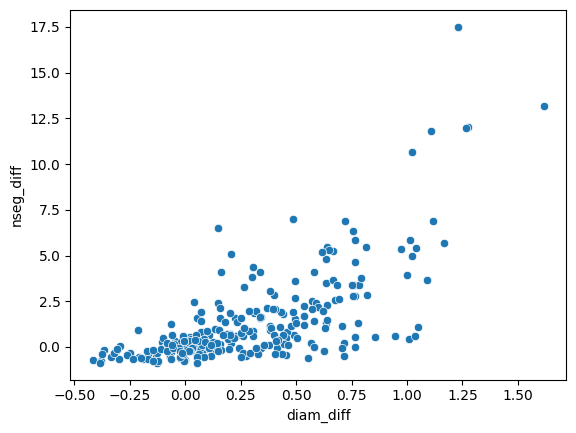

In [728]:
sns.scatterplot(data = df_edges,x='diam_diff',y='nseg_diff')

<AxesSubplot:xlabel='post_diam', ylabel='post_nseg'>

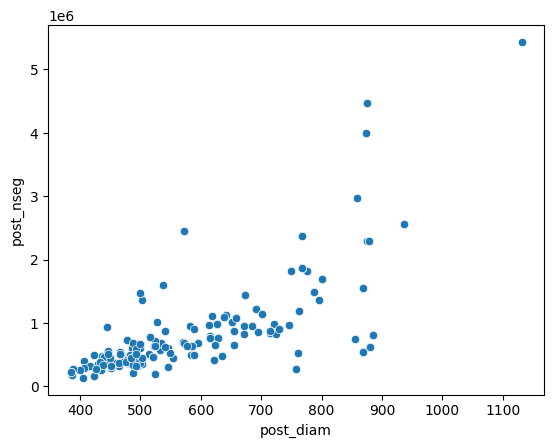

In [672]:
sns.scatterplot(data = df_edges,x='post_diam',y='post_nseg')

<AxesSubplot:xlabel='post_diam', ylabel='post_tips'>

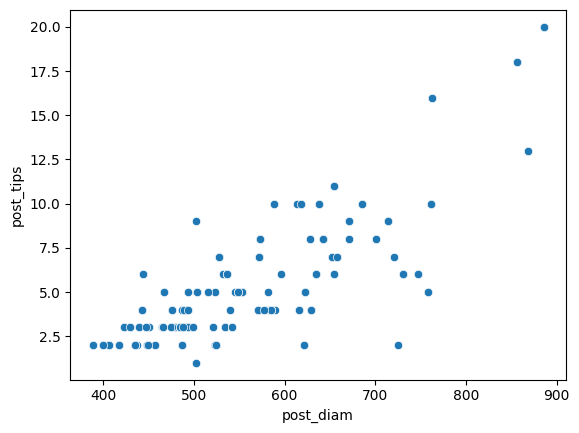

In [671]:
sns.scatterplot(data = df_edges,x='post_diam',y='post_tips')

<AxesSubplot:xlabel='structure', ylabel='weight'>

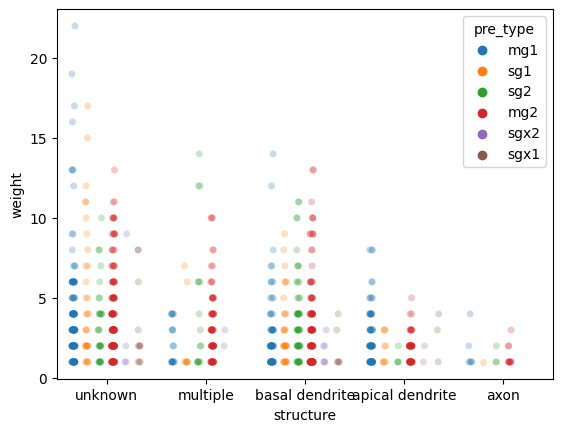

In [190]:
pre_types = ['mg1','mg2','sg1','sg2','sgx1','sgx2']
post_types = ['lf','lg']
hfig,ax = plt.subplots(1)
sns.stripplot(ax = ax,data = df_edges[(df_edges['pre_type'].isin(pre_types)) & (df_edges['post_type'].isin(post_types))],
              x='structure',y = 'weight',hue='pre_type',dodge=True,alpha=0.25)
# plt.title('mgs pre')

Text(0.5, 1.0, 'sgxs pre')

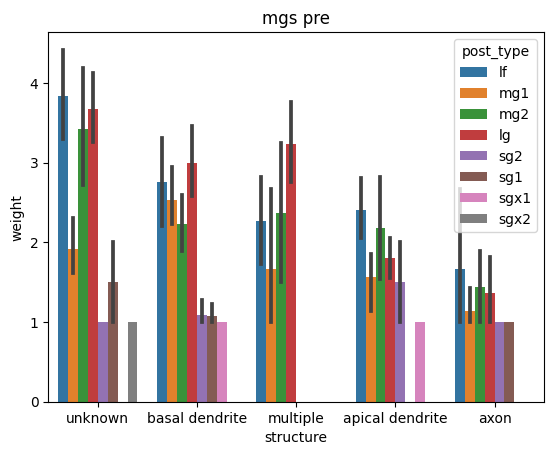

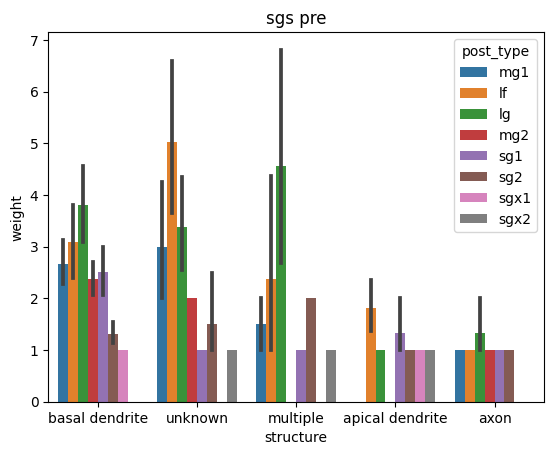

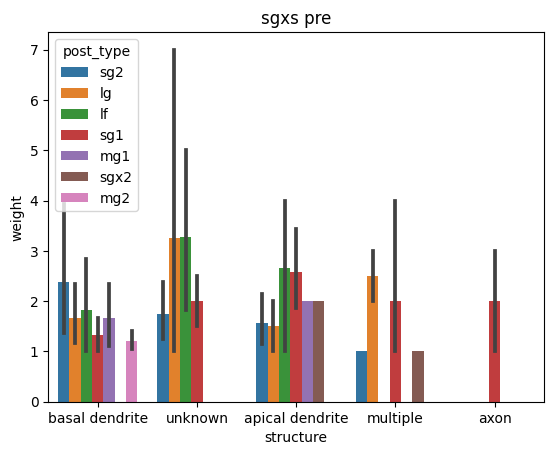

In [189]:
post_types = ['mg1','mg2','sg1','sg2','sgx1','sgx2','lf','lg']

# hfig,ax = plt.subplots(1)
# sns.barplot(ax = ax,data = df_edges[(df_edges['pre_type'].isin(post_types))& (df_edges['post_type'].isin(post_types))],x='structure',y = 'weight',hue='post_type')
# plt.title('all sgs and mgs pre')

hfig,ax = plt.subplots(1)
sns.barplot(ax = ax,data = df_edges[(df_edges['pre_type'].isin(['mg1','mg2']))& (df_edges['post_type'].isin(post_types))],x='structure',y = 'weight',hue='post_type')
plt.title('mgs pre')

hfig,ax = plt.subplots(1)
sns.barplot(ax = ax,data = df_edges[(df_edges['pre_type'].isin(['sg1','sg2']))& (df_edges['post_type'].isin(post_types))],x='structure',y = 'weight',hue='post_type')
plt.title('sgs pre')

hfig,ax = plt.subplots(1)
sns.barplot(ax = ax,data = df_edges[(df_edges['pre_type'].isin(['sgx1','sgx2']))& (df_edges['post_type'].isin(post_types))],x='structure',y = 'weight',hue='post_type')
plt.title('sgxs pre')

# hfig,ax = plt.subplots(1)
# sns.barplot(ax = ax,data = df_edges[(df_edges['pre_type'].isin(['sg1','sg2']))& (df_edges['post_type'].isin(post_types))],x='structure',y = 'weight',hue='post_type')

In [674]:
post_types = ['mg1','mg2','sg1','sg2','sgx1','sgx2']
df_edges[(df_edges['structure'].isin(['unknown','apical dendrite'])) & (df_edges['pre_type'].isin(post_types)) & (df_edges['post_type'].isin(post_types))][['pre_type','post_type']].value_counts()

pre_type  post_type
mg2       mg1          55
mg1       mg2          52
sgx2      sg1          13
sgx1      sg2          12
sg1       sg2           5
sg2       mg1           4
          sg1           4
mg1       sg2           4
mg2       mg2           2
          sg1           2
sg1       sgx2          2
mg1       mg1           2
mg2       sgx1          1
sg1       mg2           1
mg1       sgx2          1
sg2       sgx1          1
sgx1      sgx2          1
sgx2      mg1           1
dtype: int64

In [680]:
post_types = ['mg1','mg2','sg1','sg2','sgx1','sgx2']
df_edges[(df_edges['structure'].isin(['basal dendrite'])) & (df_edges['pre_type'].isin(post_types)) & (df_edges['post_type'].isin(post_types))][['pre_type','post_type']].value_counts()

pre_type  post_type
mg2       mg1          171
sg2       mg1          159
mg1       mg2          145
sg1       mg2          112
sg2       sg1           62
sgx1      mg2           20
sg1       sg2           19
sgx1      sg2           16
mg2       sg1           13
mg1       sg2           10
sgx2      mg1            9
          sg1            6
sg2       sgx1           2
mg2       sg2            1
          sgx1           1
sg1       sg1            1
dtype: int64

In [682]:
post_types = ['mg1','mg2','sg1','sg2','sgx1','sgx2']

print(df_edges[(df_edges['structure'].isin(['unknown','apical dendrite']))& (df_edges['post_type'].isin(post_types))]['diam_diff'].describe())

print(df_edges[(df_edges['structure'].isin(['basal dendrite']))& (df_edges['post_type'].isin(post_types))]['diam_diff'].describe())

count    22.000000
mean      0.019476
std       0.225083
min      -0.374388
25%      -0.126757
50%      -0.004623
75%       0.136645
max       0.598844
Name: diam_diff, dtype: float64
count    227.000000
mean       0.326292
std        0.369126
min       -0.417603
25%        0.052856
50%        0.287864
75%        0.579142
max        1.616185
Name: diam_diff, dtype: float64


what about among the category with the most variability in size (current sgs)?

In [683]:
post_types = ['sg1','sg2']

print(df_edges[(df_edges['structure'].isin(['unknown','apical dendrite']))& (df_edges['post_type'].isin(post_types))]['diam_diff'].describe())

print(df_edges[(df_edges['structure'].isin(['basal dendrite']))& (df_edges['post_type'].isin(post_types))]['diam_diff'].describe())

count    7.000000
mean    -0.070511
std      0.192620
min     -0.374388
25%     -0.161371
50%     -0.110997
75%      0.077108
max      0.160333
Name: diam_diff, dtype: float64
count    49.000000
mean      0.017686
std       0.206435
min      -0.417603
25%      -0.090467
50%       0.068596
75%       0.154567
max       0.383142
Name: diam_diff, dtype: float64


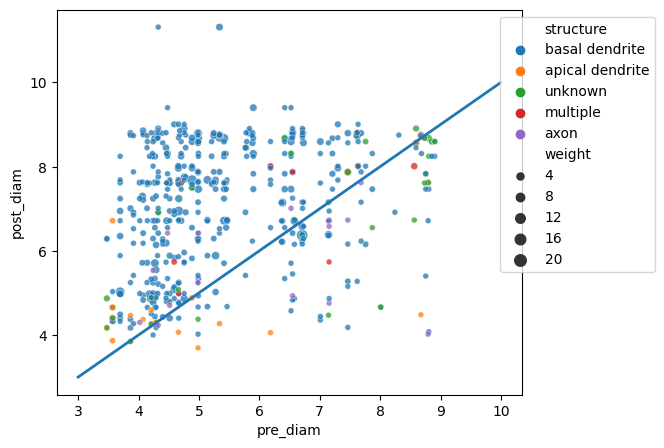

In [206]:
post_types = ['mg1','mg2','sg1','sg2','sgx1','sgx2']

hfig,ax = plt.subplots(1,figsize=(6,5))
sns.scatterplot(data = df_edges[ (df_edges['post_type'].isin(post_types))],
                x='pre_diam',y = 'post_diam',color='red',alpha = 0.75,size='weight',hue='structure')
plt.plot([3, 10], [3,10], linewidth=2)
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.3, 1))


<AxesSubplot:xlabel='structure', ylabel='diam_diff'>

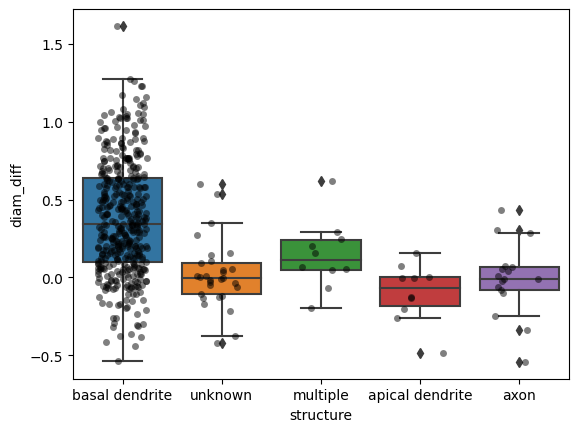

In [207]:

pre_types = ['sg1','sg2','mg1','mg2']#,'sg1','sg2','sgx1','sgx2']
post_types = ['sg1','sg2','mg1','mg2']

hfig,ax = plt.subplots(1)
sns.boxplot(data = df_edges[(df_edges['pre_type'].isin(pre_types))& (df_edges['post_type'].isin(post_types))],
              x='structure',y = 'diam_diff')#,jitter=0.25,alpha = 0.5)
sns.stripplot(data = df_edges[(df_edges['pre_type'].isin(pre_types))& (df_edges['post_type'].isin(post_types))],
              x='structure',y = 'diam_diff',color='black',jitter=0.25,alpha = 0.5)

<AxesSubplot:xlabel='structure', ylabel='weight'>

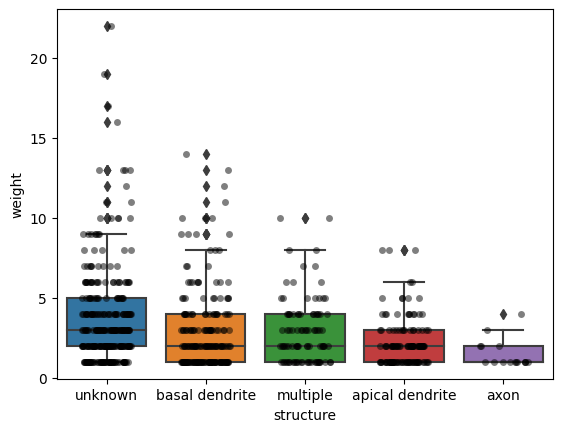

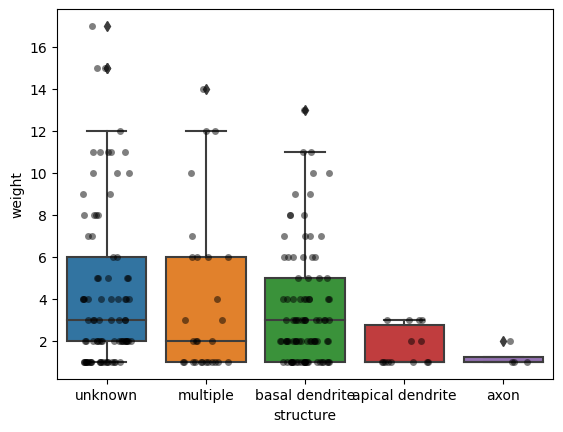

In [208]:
pre_types = ['mg1','mg2']#,'sg1','sg2','sgx1','sgx2']
post_types = ['lg','lf']

hfig,ax = plt.subplots(1)
sns.boxplot(data = df_edges[(df_edges['pre_type'].isin(pre_types))& (df_edges['post_type'].isin(post_types))],
              x='structure',y = 'weight')#,jitter=0.25,alpha = 0.5)
sns.stripplot(data = df_edges[(df_edges['pre_type'].isin(pre_types))& (df_edges['post_type'].isin(post_types))],
              x='structure',y = 'weight',color='black',jitter=0.25,alpha = 0.5)

pre_types = ['sg1','sg2']#,'sg1','sg2','sgx1','sgx2']
post_types = ['lg','lf']

hfig,ax = plt.subplots(1)
sns.boxplot(data = df_edges[(df_edges['pre_type'].isin(pre_types))& (df_edges['post_type'].isin(post_types))],
              x='structure',y = 'weight')#,jitter=0.25,alpha = 0.5)
sns.stripplot(data = df_edges[(df_edges['pre_type'].isin(pre_types))& (df_edges['post_type'].isin(post_types))],
              x='structure',y = 'weight',color='black',jitter=0.25,alpha = 0.5)

In [ ]:
ax = df.plot.bar(stacked=True)

In [799]:
pre_types = ['mg1','mg2']#,'sg1','sg2']#,'sgx1','sgx2']
post_types = ['lg','lf']
df_edges[(df_edges['pre_type'].isin(pre_types))& (df_edges['post_type'].isin(post_types))][['pre_type','post_type','structure']].value_counts()

pre_type  post_type  structure      
mg2       lg         unknown            157
mg1       lf         unknown            148
mg2       lg         basal dendrite     127
mg1       lf         apical dendrite     78
                     basal dendrite      73
mg2       lg         multiple            73
                     apical dendrite     52
mg1       lf         multiple            19
mg2       lf         basal dendrite      11
          lg         axon                11
          lf         unknown              7
mg1       lf         axon                 6
mg2       lf         apical dendrite      5
                     multiple             3
dtype: int64

In [800]:
pre_types = ['sg1','sg2']#,'sg1','sg2']#,'sgx1','sgx2']
post_types = ['lg','lf']
df_edges[(df_edges['pre_type'].isin(pre_types))& (df_edges['post_type'].isin(post_types))][['pre_type','post_type','structure']].value_counts()

pre_type  post_type  structure      
sg2       lg         basal dendrite     48
sg1       lf         unknown            30
sg2       lg         unknown            29
sg1       lf         basal dendrite     27
sg2       lg         multiple           15
sg1       lf         apical dendrite     9
                     multiple            8
sg2       lf         basal dendrite      4
          lg         axon                3
                     apical dendrite     2
sg1       lf         axon                1
sg2       lf         apical dendrite     1
                     unknown             1
dtype: int64

## restrict to subset of neuron types

In [75]:
network_types = ['mg1','mg2','lg','lf','sg1','sg2','sgx','grc','aff']

df_edges = df_edges[(df_edges['pre_type'].isin(network_types))&(df_edges['post_type'].isin(network_types))]

In [76]:
# df_edges[["pre_type","post_type"]].value_counts()

In [354]:
# print(f'comprising {len(df_edges)} unique edges among:')
print(f'{df_edges[["pre_type","post_type"]].value_counts().reset_index(name="counts")["counts"].sum()} unique edges among:')
print(f'{len(df_edges["pre"].unique())} unique pre synaptic cells - to - {len(df_edges["post"].unique())} unique post-synaptic cells (counts different structures on same cell as same)')

2923 unique edges among:
146 unique pre synaptic cells - to - 881 unique post-synaptic cells (counts different structures on same cell as same)


In [ ]:
df_edge_counts = df_edges[['pre_type','post_type']].value_counts().reset_index(name='counts')

# mask = df_edge_counts['pre_type'].str.lower().isin(['mg1']) & df_edge_counts['post_type'].str.lower().isin(['lf'])
# display(df_edge_counts[mask])

mask = df_edges['pre_type'].str.lower().isin(['mg1']) & df_edges['post_type'].str.lower().isin(['lf'])
display(df_edges[mask].groupby(['pre_type','post_type']).sum(numeric_only=True))

# mask = df_edge_counts['pre_type'].str.lower().isin(['mg2']) & df_edge_counts['post_type'].str.lower().isin(['lg'])
# display(df_edge_counts[mask])

mask = df_edges['pre_type'].str.lower().isin(['mg2']) & df_edges['post_type'].str.lower().isin(['lg'])
display(df_edges[mask].groupby(['pre_type','post_type']).sum(numeric_only=True))

# mask = df_edge_counts['pre_type'].str.lower().isin(['mg1']) & df_edge_counts['post_type'].str.lower().isin(['mg2'])
# display(df_edge_counts[mask])

mask = df_edges['pre_type'].str.lower().isin(['mg1']) & df_edges['post_type'].str.lower().isin(['mg2'])
display(df_edges[mask].groupby(['pre_type','post_type']).sum(numeric_only=True))

# mask = df_edge_counts['pre_type'].str.lower().isin(['mg2']) & df_edge_counts['post_type'].str.lower().isin(['mg1'])
# display(df_edge_counts[mask])

mask = df_edges['pre_type'].str.lower().isin(['mg2']) & df_edges['post_type'].str.lower().isin(['mg1'])
display(df_edges[mask].groupby(['pre_type','post_type']).sum(numeric_only=True))

## Cell Structures included

If want to count different cell structure targets as unique, use the following cell.  

If not, ignore it

In [ ]:
edge_scaling = 10
df = pd.DataFrame(edge_list,columns = ['pre','post','structure'])

df_edges = deepcopy(df.value_counts().reset_index(name='weight'))
df_edges['weight_norm'] = (df_edges['weight'] / df_edges['weight'].max()) * edge_scaling

for i,r in df_edges.iterrows():
    df_edges.loc[i,'pre_type']=ell.vs.find(r['pre'])['cell_type']
    df_edges.loc[i,'post_type']=ell.vs.find(r['post'])['cell_type']

In [ ]:
# for each unique edge, get the cell-type pair and structure
for i,r in df_edges.iterrows():
    ell.add_edge(r['pre'],r['post'],weight = r['weight_norm'],structure = r['structure'])

In [ ]:
# print(f'comprising {len(df_edges)} unique edges among:')
print(f'{df_edges[["pre_type","post_type","structure"]].value_counts().reset_index(name="counts")["counts"].sum()} unique edges among:')
print(f'{len(df["pre"].unique())} unique pre synaptic cells - to - {len(df["post"].unique())} unique post-synaptic cells (counts different structures on same cell as different)')

In [ ]:
df_edge_counts = df_edges[['pre_type','post_type','structure']].value_counts().reset_index(name='counts')

# mask = df_edge_counts['pre_type'].str.lower().isin(['mg1']) & df_edge_counts['post_type'].str.lower().isin(['lf'])
# display(df_edge_counts[mask])

mask = df_edges['pre_type'].str.lower().isin(['mg1']) & df_edges['post_type'].str.lower().isin(['lf'])
display(df_edges[mask].groupby(['pre_type','post_type','structure']).sum(numeric_only=True))

# mask = df_edge_counts['pre_type'].str.lower().isin(['mg2']) & df_edge_counts['post_type'].str.lower().isin(['lg'])
# display(df_edge_counts[mask])

mask = df_edges['pre_type'].str.lower().isin(['mg2']) & df_edges['post_type'].str.lower().isin(['lg'])
display(df_edges[mask].groupby(['pre_type','post_type','structure']).sum(numeric_only=True))

# mask = df_edge_counts['pre_type'].str.lower().isin(['mg1']) & df_edge_counts['post_type'].str.lower().isin(['mg2'])
# display(df_edge_counts[mask])

mask = df_edges['pre_type'].str.lower().isin(['mg1']) & df_edges['post_type'].str.lower().isin(['mg2'])
display(df_edges[mask].groupby(['pre_type','post_type','structure']).sum(numeric_only=True))

# mask = df_edge_counts['pre_type'].str.lower().isin(['mg2']) & df_edge_counts['post_type'].str.lower().isin(['mg1'])
# display(df_edge_counts[mask])

mask = df_edges['pre_type'].str.lower().isin(['mg2']) & df_edges['post_type'].str.lower().isin(['mg1'])
display(df_edges[mask].groupby(['pre_type','post_type','structure']).sum(numeric_only=True))

## Check for any synapses on self

In [ ]:
vx_sizes = [16, 16, 30]

for i,r in df_edges.iterrows():
    if r['pre']==r['post']:
        print(r['pre'])
        cell = ecrest(settings_dict,filepath = nodefiles[r['pre']])
        for syn_ in cell.cell_data['end_points']['post-synaptic']:
            post_seg = syn_[3]
            for i,s in enumerate(syn_[0:3]):
                syn_[i] = s/vx_sizes[i] 
            if post_seg in [str(a) for b in base_segments[r['pre']].values() for a in b]:
                print(f'delete synapse {syn_}')       
        

In [ ]:
print(f'{len(ell.vs)} cells in the network that fall within cell types of interest (nodes in the graph):')
print('')
for ctype in network_types:
    these_cells = ell.vs.select(lambda v: ctype in v['cell_type'])
    print(f'{len(these_cells)} {ctype} cells.')# {len(ell.vs.select(lambda v: 'lg' in v['cell_type']))} lg cells. {len(e
print('')

df_allsyn = pd.DataFrame(cells_with_synapses)
print(f'{len(df_allsyn[df_allsyn[1].isin(["mg1","mg2"])])} of these are mg cells with post-synaptic segments labeled for their synapses')
# print(f'{len(df_edges[df_edges['pre_type'].str.contains("mg")])} of these are mg_ cells with post-synaptic segments labeled for their synapses')

print(f'{df_allsyn[df_allsyn[1].isin(["mg1","mg2"])][2].sum()} total post-synapstic segments labeled from mg_ cells in the network')

# cells_without_synapses

df_nosyn = pd.DataFrame(cells_without_synapses)

# print(f'{len(df_nosyn[df_nosyn[1].str.contains(["mg1","mg2"])])} mg1/2 cells without labeled synapses')
print(f'{len(df_nosyn[df_nosyn[1].isin(["mg1","mg2"])])} mg1/2 cells without labeled synapses')


######
print('')
print(f'{len(df_allsyn[df_allsyn[1].isin(["sg1","sg2","sgx"])])} of these are sg cells with post-synaptic segments labeled for their synapses')
# print(f'{len(df_edges[df_edges['pre_type'].str.contains("mg")])} of these are mg_ cells with post-synaptic segments labeled for their synapses')

print(f'{df_allsyn[df_allsyn[1].isin(["sg1","sg2","sgx"])][2].sum()} total post-synapstic segments labeled from sg_ cells in the network')

# cells_without_synapses

df_nosyn = pd.DataFrame(cells_without_synapses)

# print(f'{len(df_nosyn[df_nosyn[1].str.contains(["mg1","mg2"])])} mg1/2 cells without labeled synapses')
print(f'{len(df_nosyn[df_nosyn[1].isin(["sg1","sg2","sgx"])])} sg_ cells without labeled synapses')

######
print('')
print(f'{len(df_allsyn[df_allsyn[1].isin(["grc"])])} of these are grc cells with post-synaptic segments labeled for their synapses')
# print(f'{len(df_edges[df_edges['pre_type'].str.contains("mg")])} of these are mg_ cells with post-synaptic segments labeled for their synapses')

print(f'{df_allsyn[df_allsyn[1].isin(["grc"])][2].sum()} total post-synapstic segments labeled from grc cells in the network')

# cells_without_synapses

df_nosyn = pd.DataFrame(cells_without_synapses)

# print(f'{len(df_nosyn[df_nosyn[1].str.contains(["mg1","mg2"])])} mg1/2 cells without labeled synapses')
print(f'{len(df_nosyn[df_nosyn[1].isin(["grc"])])} grc cells without labeled synapses')

summary of mg

In [79]:
print(f'{len(df_syn_post)} synapses with reconstructed partners in current network,')
print(f'{len(df_edges)} unique edges total (of various weights)')

print('')

print(f'{df_edges[df_edges["pre_type"].str.contains("mg")]["weight"].sum()} synapses with reconstructed partners from mg cells pre-synaptically.')
print(f'{df_edges[df_edges["pre_type"].str.contains("sg")]["weight"].sum()} synapses with reconstructed partners from sg cells pre-synaptically.')
print(f'{df_edges[df_edges["pre_type"].str.contains("grc")]["weight"].sum()} synapses with reconstructed partners from grc cells pre-synaptically.')

print('')

print(f'{len(np.unique(df_edges[df_edges["pre_type"]=="mg1"]["pre"]))} mg1 cells with ')
print(f'{df_edges[df_edges["pre_type"]=="mg1"]["weight"].sum()} connected synapses with a reconstructed partner in these mg1')

print(f'{len(np.unique(df_edges[df_edges["post_type"]=="mg1"]["post"]))} mg1 cells (post)')
print(f'{df_edges[df_edges["post_type"]=="mg1"]["weight"].sum()} connected synapses with a reconstructed partner in these mg1')

print('')
print(f'{len(np.unique(df_edges[df_edges["pre_type"]=="mg2"]["pre"]))} mg2 cells (pre)')
print(f'{df_edges[df_edges["pre_type"]=="mg2"]["weight"].sum()} connected synapses with a reconstructed partner in these mg2')

print(f'{len(np.unique(df_edges[df_edges["post_type"]=="mg2"]["post"]))} mg2 cells (post)')
print(f'{df_edges[df_edges["post_type"]=="mg2"]["weight"].sum()} connected synapses with a reconstructed partner in these mg2')

print('')
print(f'{len(np.unique(df_edges[df_edges["pre_type"]=="sg1"]["pre"]))} sg1 cells (pre) ')
print(f'{df_edges[df_edges["pre_type"]=="sg1"]["weight"].sum()} connected synapses with a reconstructed partner in these sg1')

print(f'{len(np.unique(df_edges[df_edges["post_type"]=="sg1"]["post"]))} sg1 cells (post)')
print(f'{df_edges[df_edges["post_type"]=="sg1"]["weight"].sum()} connected synapses with a reconstructed partner in these sg1')

print('')
print(f'{len(np.unique(df_edges[df_edges["pre_type"]=="sg2"]["pre"]))} sg2 cells (pre)')
print(f'{df_edges[df_edges["pre_type"]=="sg2"]["weight"].sum()} connected synapses with a reconstructed partner in these sg2')

print(f'{len(np.unique(df_edges[df_edges["post_type"]=="sg2"]["post"]))} sg2 cells (post)')
print(f'{df_edges[df_edges["post_type"]=="sg2"]["weight"].sum()} connected synapses with a reconstructed partner in these sg2')

print('')
print(f'{len(np.unique(df_edges[df_edges["pre_type"]=="sgx"]["pre"]))} sgx cells (pre)')
print(f'{df_edges[df_edges["pre_type"]=="sgx"]["weight"].sum()} connected synapses with a reconstructed partner in these sgx')

print(f'{len(np.unique(df_edges[df_edges["post_type"]=="sgx"]["post"]))} sgx cells (post)')
print(f'{df_edges[df_edges["post_type"]=="sgx"]["weight"].sum()} connected synapses with a reconstructed partner in these sgx')

print('')
print(f'{len(np.unique(df_edges[df_edges["pre_type"]=="grc"]["pre"]))} grc cells (pre)')
print(f'{df_edges[df_edges["pre_type"]=="grc"]["weight"].sum()} connected synapses with a reconstructed partner in these grc')

print(f'{len(np.unique(df_edges[df_edges["post_type"]=="grc"]["post"]))} grc cells (post)')
print(f'{df_edges[df_edges["post_type"]=="grc"]["weight"].sum()} connected synapses with a reconstructed partner in these grc')

# with pd.option_context('display.max_rows', 10):
#     display(df_edges)

7525 synapses with reconstructed partners in current network,
1602 unique edges total (of various weights)

3481 synapses with reconstructed partners from mg cells pre-synaptically.
1595 synapses with reconstructed partners from sg cells pre-synaptically.
413 synapses with reconstructed partners from grc cells pre-synaptically.

35 mg1 cells with 
1614 connected synapses with a reconstructed partner in these mg1
59 mg1 cells (post)
994 connected synapses with a reconstructed partner in these mg1

40 mg2 cells (pre)
1867 connected synapses with a reconstructed partner in these mg2
66 mg2 cells (post)
918 connected synapses with a reconstructed partner in these mg2

14 sg1 cells (pre) 
496 connected synapses with a reconstructed partner in these sg1
77 sg1 cells (post)
335 connected synapses with a reconstructed partner in these sg1

18 sg2 cells (pre)
874 connected synapses with a reconstructed partner in these sg2
39 sg2 cells (post)
154 connected synapses with a reconstructed partner 

## If need to delete edges to re-do something...

In [ ]:
# # if need to delete all edges...
# ell.delete_edges(range(len(ell.es)))

## querying df_edges

### print out quantifications

In [407]:
with pd.option_context('display.max_rows', 20):
    display(df_edges)

,pre,post,weight,pre_type,post_type
0,387382792,214503199,40,mg2,lg
1,473631846,305332461,30,mg2,lg
2,41579854,394191803,29,mg1,lf
3,300131090,309277229,29,mg1,lf
4,128536704,214503199,24,mg2,lg
...,...,...,...,...,...
2031,301662524,306306044,1,sgx,uk
2032,301648806,563840037,1,sg1,lf
2033,301648806,483687142,1,sg1,lx
2034,301648806,480158526,1,sg1,uk


If have structure in edges, can use next cells...

In [ ]:
mask = df_edges['pre_type'].str.lower().isin(['sg1','mg1']) & df_edges['post_type'].str.lower().isin(['mg2'])
hfig,ax = plt.subplots(1,figsize=(10,5))
sns.stripplot(ax = ax, x='structure',y='weight',data = df_edges[mask],hue='pre_type', dodge=True, alpha=0.33,jitter=0.33,s=10)
ax.tick_params(axis='x', labelrotation = 45)
ax.set_ylim(0,15)

In [ ]:
mask = df_edges['pre_type'].str.lower().isin(['mg2','sg2']) & df_edges['post_type'].str.lower().isin(['mg1'])
hfig,ax = plt.subplots(1,figsize=(10,5))
sns.stripplot(ax = ax, x='structure',y='weight',data = df_edges[mask],hue='pre_type', dodge=True, alpha=0.33,jitter=0.33,s=10)
ax.tick_params(axis='x', labelrotation = 45)
ax.set_ylim(0,15)

## Graphs

In [185]:
# df_edges[df_edges['pre_type']=='grc']

In [1665]:
# for d_ in df_edges[df_edges['pre_type']=='sg2'].groupby(['pre']):
#     print(d_)

In [ ]:
# df_map = df_edges.
# df_map = df_edges[df_edges['pre_type']=='grc'].groupby(['post_type']).sum(numeric_only=True).reset_index()
# display(df_map)

In [209]:
df_map = df_edges.groupby(['pre_type','post_type']).sum(numeric_only=True).reset_index().pivot(index='pre_type', columns='post_type', values='weight').fillna(0)
print('raw weights')
display(df_map)
# display(df_map/df_map.sum(axis=1))
print('totals across row')
display(df_map.sum(axis=1))

raw weights


post_type,dml,fov,glia,grc-d,grc-s,lf,lg,mg1,mg2,sg1,sg2,sgx1,sgx2,tsd,uk
pre_type,,,,,,,,,,,,,,,
aff,0.0,7.0,0.0,110.0,1.0,18.0,0.0,0.0,9.0,0.0,15.0,0.0,9.0,0.0,27.0
dml,38.0,10.0,0.0,0.0,4.0,36.0,27.0,33.0,50.0,43.0,19.0,0.0,0.0,6.0,26.0
grc-d,5.0,33.0,0.0,1.0,16.0,6.0,96.0,33.0,1.0,255.0,0.0,67.0,3.0,145.0,59.0
grc-s,54.0,7.0,0.0,2.0,1.0,102.0,0.0,6.0,130.0,6.0,142.0,1.0,13.0,2.0,66.0
mg1,0.0,169.0,3.0,1.0,4.0,1005.0,0.0,6.0,518.0,7.0,17.0,0.0,1.0,8.0,145.0
mg2,0.0,181.0,10.0,0.0,1.0,87.0,1216.0,552.0,7.0,18.0,6.0,2.0,0.0,157.0,191.0
sg1,0.0,181.0,1.0,1.0,19.0,387.0,0.0,2.0,331.0,4.0,59.0,0.0,3.0,0.0,50.0
sg2,1.0,258.0,4.0,3.0,0.0,15.0,433.0,484.0,3.0,173.0,5.0,3.0,0.0,122.0,105.0
sgx1,0.0,5.0,0.0,1.0,0.0,55.0,0.0,0.0,23.0,2.0,65.0,0.0,3.0,0.0,15.0


totals across row


pre_type
aff       196.0
dml       292.0
grc-d     720.0
grc-s     532.0
mg1      1884.0
mg2      2428.0
sg1      1038.0
sg2      1609.0
sgx1      169.0
sgx2      146.0
uk         24.0
dtype: float64

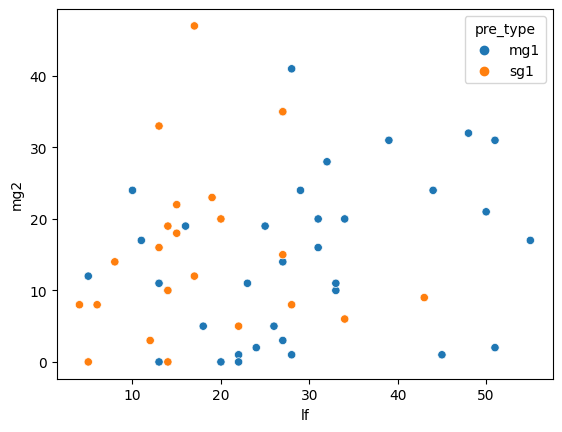

In [210]:
types_ = ['mg1','sg1']
df_map = pd.DataFrame()
for t in types_:
    df_grouped = df_edges[df_edges['pre_type']==t].groupby(
        ['pre','pre_type','post_type']).sum(numeric_only=True).reset_index().pivot(
        index='pre', columns='post_type', values='weight').fillna(0).reset_index()
    df_grouped['pre_type']=t
    df_map = pd.concat([df_map,df_grouped])
    
# for t in types_:
#     df_grouped = df_edges[df_edges['pre_type']==t].groupby(
#         ['pre','pre_type','post_type']).count().reset_index().pivot(
#         index='pre', columns='post_type', values='post').fillna(0).reset_index()
#     df_grouped['pre_type']=t
#     df_map = pd.concat([df_map,df_grouped])

ax = sns.scatterplot(data=df_map,x='lf',y='mg2',hue='pre_type')

<AxesSubplot:xlabel='lg', ylabel='mg1'>

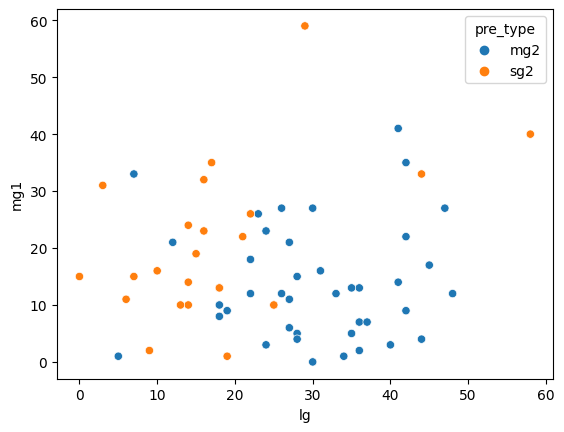

In [211]:
types_ = ['mg2','sg2']
df_map = pd.DataFrame()
for t in types_:
    df_grouped = df_edges[df_edges['pre_type']==t].groupby(
        ['pre','pre_type','post_type']).sum(numeric_only=True).reset_index().pivot(
        index='pre', columns='post_type', values='weight').fillna(0).reset_index()
    df_grouped['pre_type']=t
    df_map = pd.concat([df_map,df_grouped])

sns.scatterplot(data=df_map,x='lg',y='mg1',hue='pre_type')

In [ ]:
df_map[df_edges['post_type'].unique()].div(df_map[df_edges['post_type'].unique()].sum(axis=1),axis=0).mul(100).round(0)

### cluster map

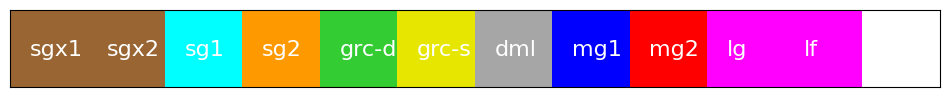

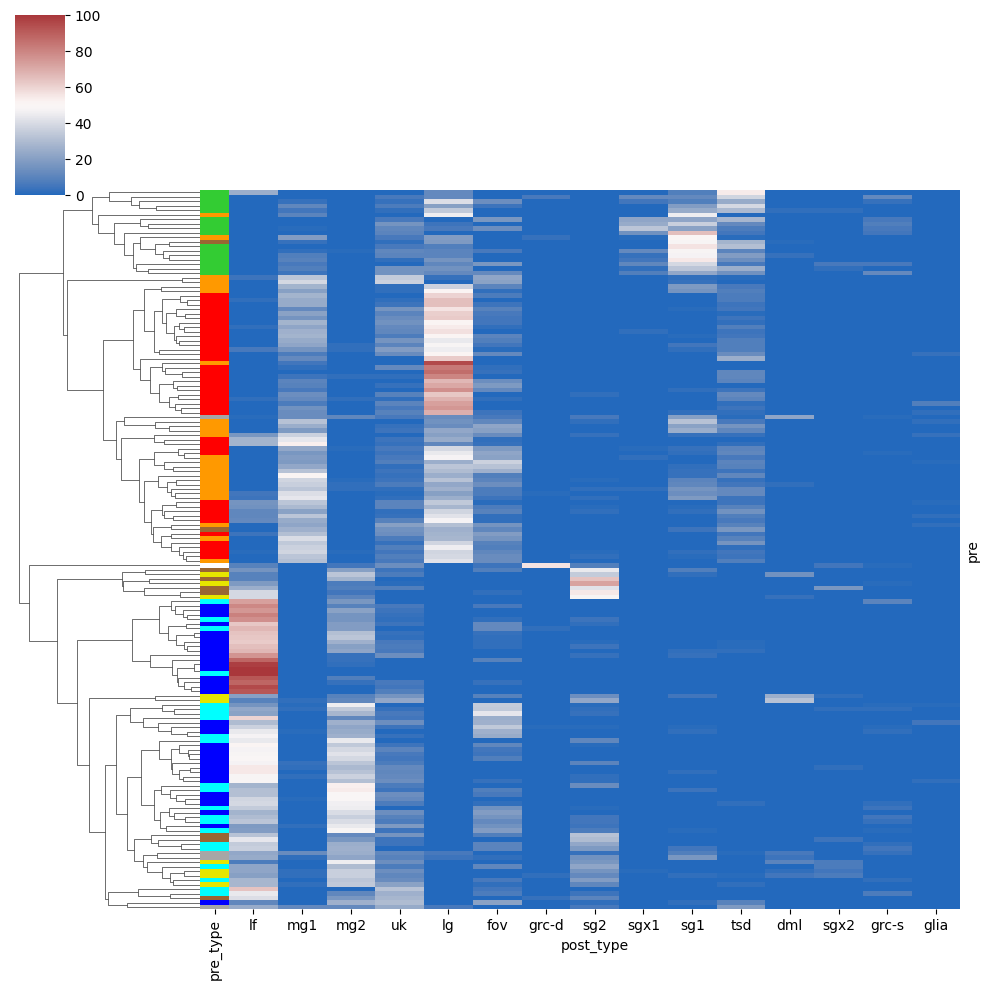

In [212]:
types_ = ['mg1','mg2','lg','lf','sg1','sg2','sgx1','sgx2','grc-d','grc-s','aff','dml']# df_edges['pre_type'].unique()
df_map = pd.DataFrame()
for t in types_:
    df_grouped = df_edges[df_edges['pre_type']==t].groupby(
        ['pre','pre_type','post_type']).sum(numeric_only=True).reset_index().pivot(
        index='pre', columns='post_type', values='weight').fillna(0).reset_index()
    
    # df_grouped = df_edges[df_edges['pre_type']==t].groupby(
    #     ['pre','pre_type','post_type']).count().reset_index().pivot(
    #     index='pre', columns='post_type', values='post').fillna(0).reset_index()
    
    df_grouped['pre_type']=t
    df_map = pd.concat([df_map,df_grouped])
    
df_map = df_map.fillna(0)

df_map = df_map.set_index('pre')


labels = df_map['pre_type'].unique()
color_pal = sns.color_palette("deep", len(labels))
# color_dict = dict(zip(labels, color_pal))
# sns.palplot(sns.color_palette("deep", len(labels)))

# color_dict = {
#     'mg2': '#0000ff',
#     'mg1': '#ff0000',
#     'sg2': '#33ccff',
#     'sg1': '#ff99cc',
#     'sgx1': '#808080',
#     'sgx2': '#808080',
#     'grc-d': '#00ff00',
#     'grc-s': ''
# }
color_dict = {
    'sgx1':'#996633',
    'sgx2':'#996633',
    'sg1':'#00ffff',
    'sg2':'#ff9900',
    'grc-d':'#33cc33',
    'grc-s':'#e6e600',
    'dml':'#a6a6a6',
    'mg1':'#0000ff',
    'mg2':'#ff0000',
    'lg':'#ff00ff',
    'lf':'#ff00ff',
    'aff':'#ffffff'
}
sns.palplot(color_dict.values())
ax = plt.gca()
ax.tick_params(left=False, bottom=False)

for i,v in enumerate(color_dict):
    ax.text(i-0.25, 0.1, v,fontsize=16,color='white') 

data_df = df_map[df_edges['post_type'].unique()].div(df_map[df_edges['post_type'].unique()].sum(axis=1),axis=0).mul(100).round(0)
sns.clustermap(data = data_df,
               method='average',
               col_cluster=False, cmap="vlag", center=50,yticklabels=False,
               row_colors = df_map['pre_type'].map(color_dict));

# data_df = df_map[df_edges['post_type'].unique()]
# cmap = sns.color_palette("blend:#d9d9d9,#000000", as_cmap=True)
# cmap.set_under('white')
# sns.clustermap(data = data_df,
#                method='average',
#                col_cluster=False, cmap=cmap, vmin=1, yticklabels=False,
#                row_colors = df_map['pre_type'].map(color_dict));


# The methods are single, complete, average, weighted, ward, median, centroid
# from https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html#scipy.cluster.hierarchy.linkage
# default for seaborn is "average"

#### Connectivity matrices

Use following for network from POSTsynaptic labeling

In [398]:
df_syn = df_syn_post
df_edges=df_syn[['pre','post','structure','pre_type','post_type']].value_counts().reset_index(name='weight')

In [399]:
for i,r in df_edges.iterrows():
    
    try:
        df_edges.loc[i,'pre_diam']=soma_diam[str(df_edges.loc[i,'pre'])]
        df_edges.loc[i,'post_diam']=soma_diam[str(df_edges.loc[i,'post'])]
    except KeyError:
        continue
    # df_edges.loc[i,'pre_nseg']=file_size[str(df_edges.loc[i,'pre'])]
    # df_edges.loc[i,'post_nseg']=file_size[str(df_edges.loc[i,'post'])]
    # df_edges.loc[i,'pre_tips']=apical_tip[str(df_edges.loc[i,'pre'])]
    # df_edges.loc[i,'post_tips']=apical_tip[str(df_edges.loc[i,'post'])]

In [400]:
df_edges.loc[:,'diam_diff'] = (df_edges['post_diam']-df_edges['pre_diam'])/df_edges['pre_diam']
# df_edges.loc[:,'nseg_diff'] = (df_edges['post_nseg']-df_edges['pre_nseg'])/df_edges['pre_nseg']

In [409]:
network_types = ['aff','grc-d','grc-s','mg1','mg2','sg1','sg2','lf','lg']#,'sg1','sg2','lg','lf','sgx1','sgx2','grc-d','grc-s','aff','dml','uk','fov']#,'sg1','sg2','grc','aff']
# network_types = (set(df_edges['pre_type'].unique()) | set(df_edges['post_type'].unique())) - set(['glia'])

# df_edges = df_edges[(df_edges['pre_type'].isin(network_types))&(df_edges['post_type'].isin(network_types))]
df_edges_sub = df_edges[(df_edges['pre_type'].isin(['aff','grc-d']))&(df_edges['post_type'].isin(['aff','grc-d','grc-s','sg1','sg2']))]

In [410]:
# df_edges_sub

In [411]:
df_edges_sub[['pre','pre_type']].groupby(['pre_type']).count()
display(df_edges_sub[['pre','pre_type']].value_counts().reset_index(
    name='weight')['pre_type'].value_counts().reset_index(name='ncells'))

df_edges_sub[['post','post_type']].groupby(['post_type']).count()
display(df_edges_sub[['post','post_type']].value_counts().reset_index(
    name='weight')['post_type'].value_counts().reset_index(name='ncells'))


,index,ncells
0,grc-d,16
1,aff,1


,index,ncells
0,sg1,83
1,grc-d,47
2,sg2,9
3,grc-s,8


post_type,grc-d,grc-s,sg1,sg2
pre_type,,,,
aff,87.0,1.0,0.0,12.0
grc-d,0.0,6.0,94.0,0.0


Text(50.722222222222214, 0.5, 'pre type')

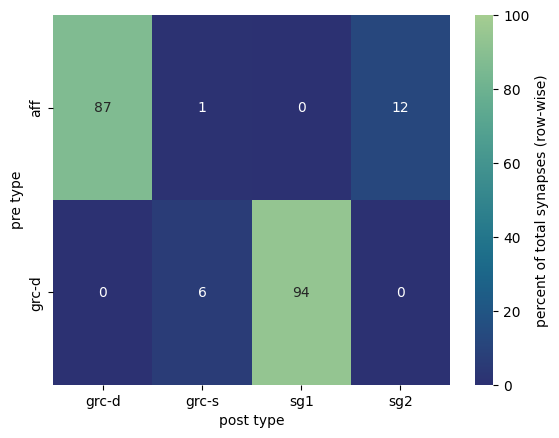

In [412]:


res = df_edges_sub.groupby(
    ['pre_type','post_type'])[['weight']].sum(numeric_only=True)#.reset_index()

denom = res.groupby('pre_type')['weight'].sum()

res.weight = np.round(res.weight / denom *100)

# res.reset_index().pivot(index='pre_type', columns='post_type', values='weight').fillna(0)

display(res.reset_index().pivot(index='pre_type', columns='post_type', values='weight').fillna(0))

ax = sns.heatmap(res.reset_index().pivot(index='pre_type', columns='post_type', values='weight').fillna(0),
            annot=True,cmap="crest_r",vmin=0,vmax=100,
           cbar_kws={'label': 'percent of total synapses (row-wise)'})

ax.set_xlabel('post type')
ax.set_ylabel('pre type')

Use following for network from PREsynaptic labeling

In [393]:
df_syn = df_syn_pre
df_edges=df_syn[['pre','post','structure','pre_type','post_type']].value_counts().reset_index(name='weight')

In [394]:
for i,r in df_edges.iterrows():
    
    try:
        df_edges.loc[i,'pre_diam']=soma_diam[str(df_edges.loc[i,'pre'])]
        df_edges.loc[i,'post_diam']=soma_diam[str(df_edges.loc[i,'post'])]
    except KeyError:
        continue
    # df_edges.loc[i,'pre_nseg']=file_size[str(df_edges.loc[i,'pre'])]
    # df_edges.loc[i,'post_nseg']=file_size[str(df_edges.loc[i,'post'])]
    # df_edges.loc[i,'pre_tips']=apical_tip[str(df_edges.loc[i,'pre'])]
    # df_edges.loc[i,'post_tips']=apical_tip[str(df_edges.loc[i,'post'])]

In [395]:
df_edges.loc[:,'diam_diff'] = (df_edges['post_diam']-df_edges['pre_diam'])/df_edges['pre_diam']
# df_edges.loc[:,'nseg_diff'] = (df_edges['post_nseg']-df_edges['pre_nseg'])/df_edges['pre_nseg']

In [396]:
network_types = ['mg1','mg2','sg1','sg2','lg','lf','grc-d','grc-s','aff']

df_edges_sub = df_edges[(df_edges['pre_type'].isin(['mg1','mg2','lg','lf']))&(df_edges['post_type'].isin(network_types))]

post_type,aff,grc-d,grc-s,lg,mg1,mg2,sg1,sg2
pre_type,,,,,,,,
lf,17.0,1.0,4.0,0.0,33.0,0.0,46.0,0.0
lg,0.0,13.0,0.0,1.0,0.0,30.0,0.0,55.0
mg1,0.0,39.0,0.0,0.0,0.0,15.0,0.0,46.0
mg2,3.0,1.0,21.0,0.0,13.0,0.0,61.0,0.0


Text(50.722222222222214, 0.5, 'post type')

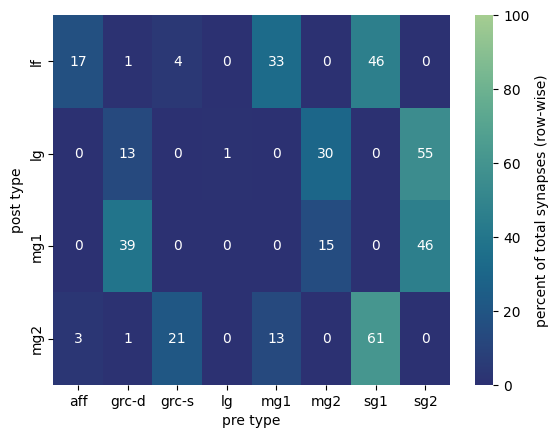

In [397]:
res = df_edges_sub.groupby(
    ['post_type','pre_type'])[['weight']].sum(numeric_only=True)#.reset_index()

denom = res.groupby('pre_type')['weight'].sum()

res.weight = np.round(res.weight / denom *100)

# res.reset_index().pivot(index='pre_type', columns='post_type', values='weight').fillna(0)

display(res.reset_index().pivot(index='pre_type', columns='post_type', values='weight').fillna(0))

ax = sns.heatmap(res.reset_index().pivot(index='pre_type', columns='post_type', values='weight').fillna(0),
            annot=True,cmap="crest_r",vmin=0,vmax=100,
           cbar_kws={'label': 'percent of total synapses (row-wise)'})

ax.set_xlabel('pre type')
ax.set_ylabel('post type')

In [1145]:
palette ={"lg": "#ff0000", "lf": "#0000ff", "mg1": "#fd9400", "mg2": "#9934ff", "sg1":"#ffff00", "sg2":"#ff33cc", "sgx":"#a6a6a6", "grc":"#000000", "aff":"#000000"}
sns.set(font_scale=1.5)

In [ ]:
# colors = ["#fd9400", "#9934ff"] #color_structure = {'mg1':'#fd9400', 'mg2':'#9934ff'}
# # Set your custom color palette
# sns.set_palette(sns.color_palette(colors))

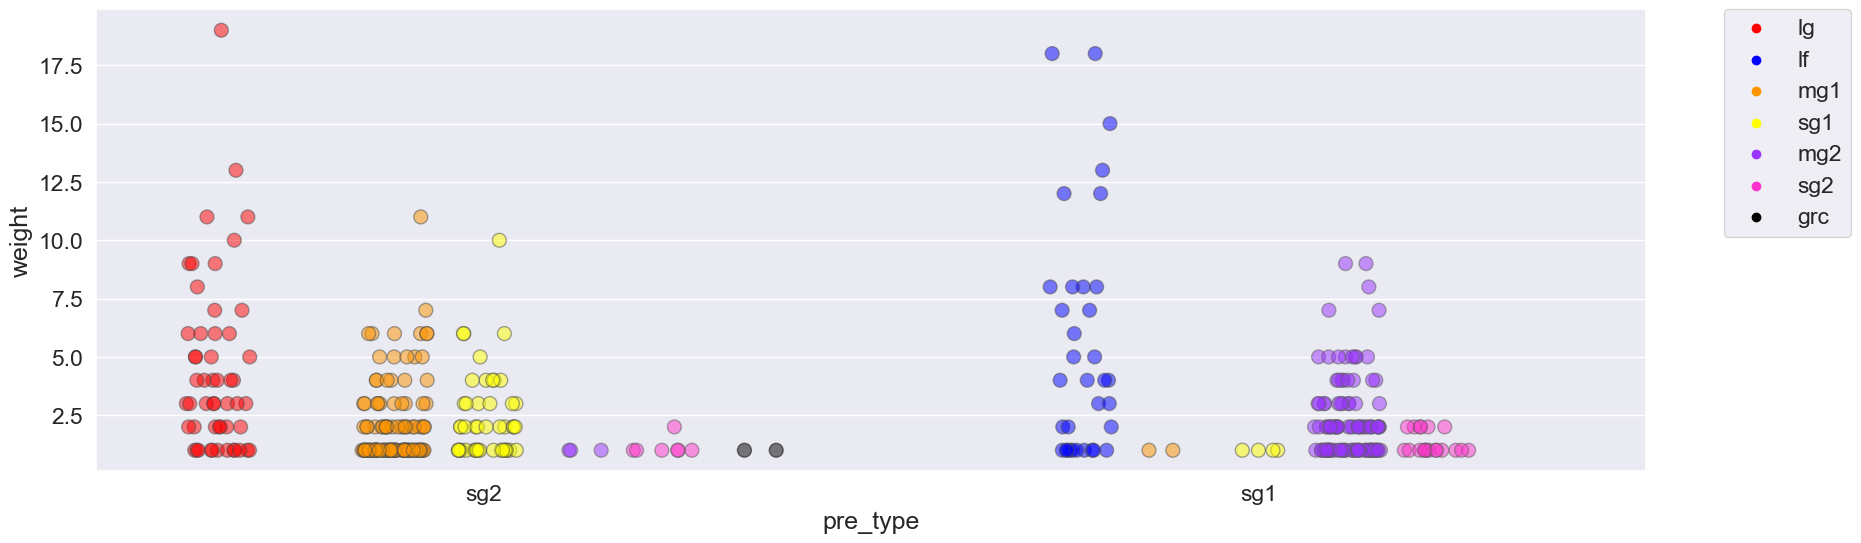

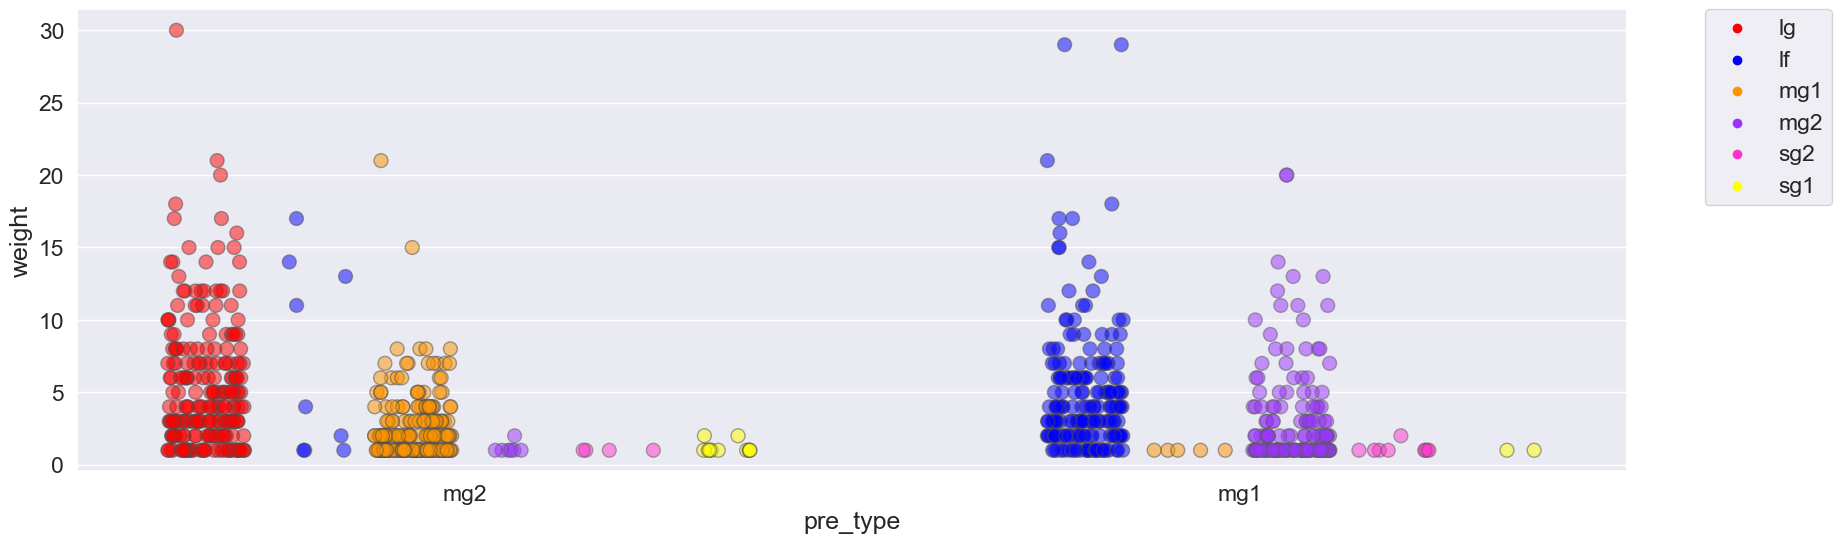

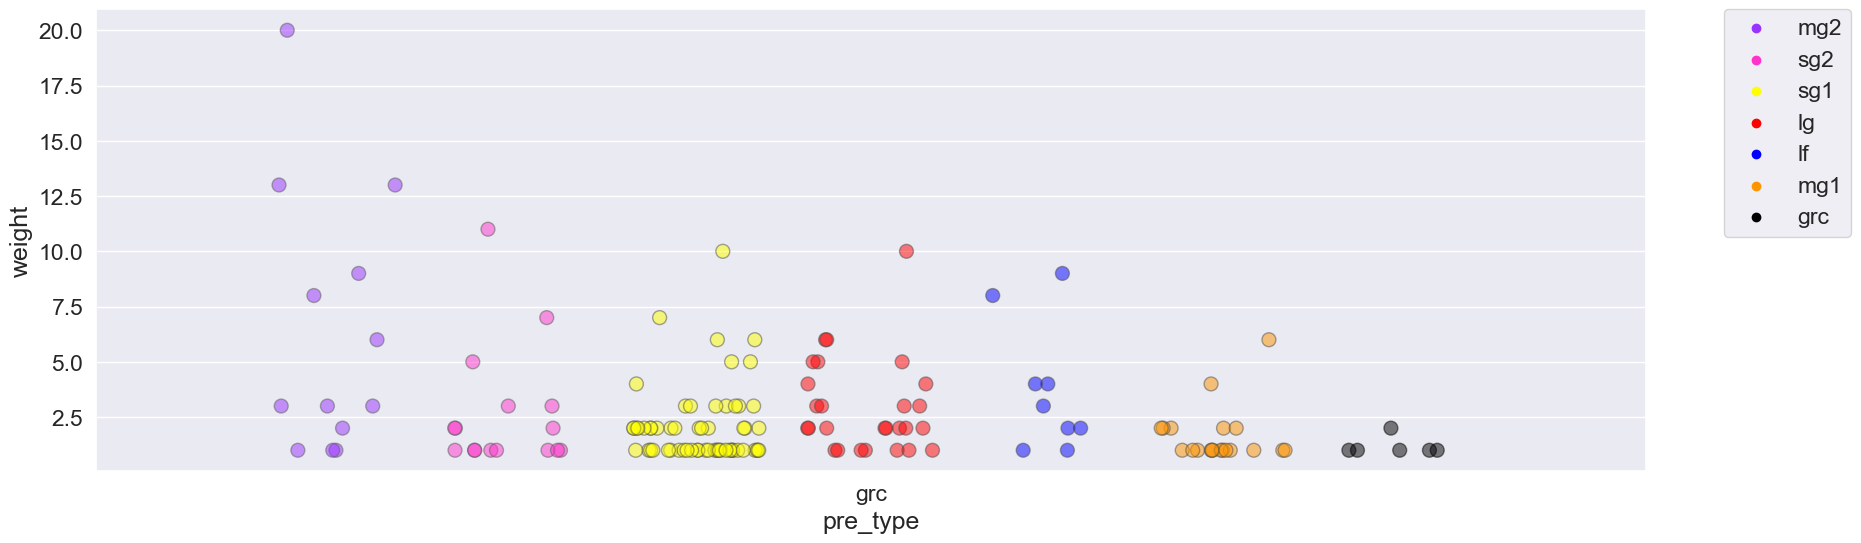

In [1151]:
# with sns.set(font_scale=1.5): # df_edges['weight'].hist(bins=20)
plt.figure(figsize=(20,6))
sns.stripplot(df_edges[df_edges["pre_type"].str.contains('sg')],x='pre_type',y='weight',hue='post_type', edgecolors="black",linewidth=1,
              dodge=True, jitter=0.3,alpha = 0.5,s=10,palette=palette)#,split=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
# sns.displot(df_edges,x='weight',hue='pre_type',multiple='dodge')

plt.figure(figsize=(20,6))
sns.stripplot(df_edges[df_edges["pre_type"].str.contains('mg')],x='pre_type',y='weight',hue='post_type', edgecolors="black",linewidth=1,
              dodge=True, jitter=0.3,alpha = 0.5,s=10,palette=palette)#,split=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
# sns.displot(df_edges,x='weight',hue='pre_type',multiple='dodge')

plt.figure(figsize=(20,6))
sns.stripplot(df_edges[df_edges["pre_type"].str.contains('grc')],x='pre_type',y='weight',hue='post_type', edgecolors="black",linewidth=1,
              dodge=True, jitter=0.3,alpha = 0.5,s=10,palette=palette)#,split=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
# sns.displot(df_edges,x='weight',hue='pre_type',multiple='dodge')

In [ ]:
plt.figure(figsize=(10,4))
sns.violinplot(df_edges,x='pre_type',y='weight',scale='count',cut=0,palette=palette);
# plt.figure(figsize=(10,4))
# sns.kdeplot(df_edges,x='weight',hue='pre_type',bw_adjust = 0.5)

In [ ]:
plt.figure(figsize=(15,8))
sns.violinplot(df_edges,x='post_type',y='weight',scale='count',cut=0,palette=palette)
sns.stripplot(df_edges,x='post_type',y='weight',color='black',alpha=0.5,jitter=0.3);
# plt.figure(figsize=(10,4))
# sns.kdeplot(df_edges,x='weight',hue='post_type',bw_adjust = 0.5)

In [ ]:
degree_in = ell.degree(mode="in")
degree_out = ell.degree(mode="out")

df_degree = pd.DataFrame({
    'cell_id': [v['name'] for v in ell.vs],
    'converge': degree_in,
    'diverge': degree_out,
    'type': [cell_type[v['name']] for v in ell.vs]
})

with pd.option_context('display.max_rows', 4):
    display(df_degree)

In [ ]:
# sns.kdeplot(df_degree,x='converge',hue='type', bw_adjust = 0.75)
plt.figure(figsize=(10,6))
sns.violinplot(df_degree[(df_degree.converge != 0)],x='type',y='converge',scale='count',cut=0,palette=palette,order=['lg','lf','mg1','mg2','sg1','sg2','sgx'])
# plt.figure(figsize=(10,4))
sns.swarmplot(df_degree[(df_degree.converge != 0)],x='type',y='converge',color='black',alpha=0.5)#,jitter=0.25)
# sns.stripplot(df_degree,x='type',y='converge',alpha=0.5,jitter=0.25)

plt.figure(figsize=(10,4))
sns.violinplot(df_degree[(df_degree['type'].isin(['mg1','mg2','sg1','sg2','sgx'])) & (df_degree.diverge != 0)],y='diverge',x='type',scale='count',cut=0,palette=palette)
# plt.figure(figsize=(10,4))
sns.swarmplot(df_degree[(df_degree['type'].isin(['mg1','mg2','sg1','sg2','sgx'])) & (df_degree.diverge != 0)],x='type',y='diverge',color='black',alpha=0.5)

In [ ]:
# sns.displot(df_degree[df_degree['type'].isin(['mg1','mg2','mgx'])],x='diverge',hue='type',multiple='dodge')

tmp = df_degree[(df_degree['type'].isin(['mg1','mg2'])) & (df_degree.diverge != 0) & (df_degree.converge != 0)].melt(id_vars=['type'], 
            value_vars=['converge', 'diverge'])

hfig,ax = plt.subplots(figsize=(10,4))
sns.violinplot(tmp,y='value',x='type',hue = 'variable',split=True,scale='count',cut=0,palette={"converge": "#808080", "diverge": "#d0d0d0"},inner=None)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
ax.set(ylim=(0, 40))

In [ ]:
display(df_degree[(df_degree['type'].isin(['mg1','mg2']))])

In [ ]:
display(df_degree[(df_degree['type'].isin(['mg1','mg2']))& (df_degree.diverge != 0) & (df_degree.converge != 0)])

In [ ]:
pruned_vs = ell.vs.select([v for v, b in enumerate(ell.vs) if 'mg' in b['cell_type']])

pruned_graph = ell.subgraph(pruned_vs)

degree_all = pruned_graph.degree(mode="out")


In [ ]:
degree_in = pruned_graph.degree(mode="in")
degree_out = pruned_graph.degree(mode="out")

df_degree = pd.DataFrame({
    'cell_id': [v['name'] for v in pruned_graph.vs],
    'converge': degree_in,
    'diverge': degree_out,
    'type': [cell_type[v['name']] for v in pruned_graph.vs]
})

with pd.option_context('display.max_rows', 4):
    display(df_degree)

In [ ]:
# sns.displot(df_degree[df_degree['type'].isin(['mg1','mg2','mgx'])],x='diverge',hue='type',multiple='dodge')

tmp = df_degree[(df_degree.diverge != 0) & (df_degree.converge != 0)].melt(id_vars=['type'], 
            value_vars=['converge', 'diverge'])

hfig,ax = plt.subplots(figsize=(10,4))
sns.violinplot(tmp,y='value',x='type',hue = 'variable',split=True,scale='count',cut=0,palette={"converge": "#808080", "diverge": "#d0d0d0"},inner=None)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
ax.set(ylim=(0, 40))

In [ ]:
color_dict = {"mg1": "orange", "lf": "red", "mg2": "purple", "lg": "blue"}

# for cell_type in ell.vs["cell_type"]:

for v in ell.vs:
    try:
        v["color"] = color_dict[v['cell_type']]
    except:
        v["color"] = 'black'
# ell.vs["color"] = [try: color_dict[cell_type] except: 'black' for cell_type in ell.vs["cell_type"]]

In [ ]:
color_dict = {"unknown": "brown", "apical dendrite": "red", "basal dendrite": "orange", "axon": "green", "multiple":"gray"}

# for cell_type in ell.vs["cell_type"]:

for e in ell.es:
    try:
        e["color"] = color_dict[e['structure']]
    except:
        e["color"] = 'black'
        # print(e)

In [ ]:
degree_all = ell.degree(mode="in")

# for i,d in enumerate(degree_all):
    # print(ell.vs[i]['cell_type'],d)

# labels = [n['name'] for n in ell.vs]

visual_style = {}
# visual_style["layout"] = ell.layout("fr")
visual_style["vertex_label_size"] = 12
visual_style["vertex_label_color"] = "white"
visual_style["vertex_label"] = degree_all
# visual_style["arrow_size"]=0.1


ig_plot(ell,edge_width = ell.es['weight'],
        vertex_color=ell.vs['color'],
        edge_color = ell.es['color'], 
        **visual_style)#,vertex_label=labels)

In [ ]:
pruned_vs = ell.vs.select([v for v, b in enumerate(ell.vs) if 'mg' in b['cell_type']])

pruned_graph = ell.subgraph(pruned_vs)

degree_all = pruned_graph.degree(mode="out")

visual_style = {}
# visual_style["layout"] = ell.layout("fr")
visual_style["vertex_label_size"] = 12
visual_style["vertex_label_color"] = "white"
visual_style["vertex_label"] = degree_all

ig_plot(pruned_graph,edge_width = pruned_graph.es['weight'],
        vertex_color=pruned_graph.vs['color'],
        edge_color = pruned_graph.es['color'],
        **visual_style)#,vertex_label=labels)

In [ ]:
pruned_vs = ell.vs.select([v for v, b in enumerate(ell.vs) if b['cell_type'] in ['mg2','mgx','lg','lx']])

pruned_graph = ell.subgraph(pruned_vs)

degree_all = pruned_graph.degree(mode="out")

visual_style = {}
# visual_style["layout"] = ell.layout("fr")
visual_style["vertex_label_size"] = 12
visual_style["vertex_label_color"] = "white"
visual_style["vertex_label"] = degree_all

ig_plot(pruned_graph,edge_width = pruned_graph.es['weight'],
        vertex_color=pruned_graph.vs['color'],
        edge_color = pruned_graph.es['color'], 
        **visual_style)#,vertex_label=labels)

In [ ]:
pruned_vs = ell.vs.select([v for v, b in enumerate(ell.vs) if b['cell_type'] in ['mg2','mgx','lf','lx']])

pruned_graph = ell.subgraph(pruned_vs)

degree_all = pruned_graph.degree(mode="in")

visual_style = {}
# visual_style["layout"] = ell.layout("fr")
visual_style["vertex_label_size"] = 12
visual_style["vertex_label_color"] = "white"
visual_style["vertex_label"] = degree_all

ig_plot(pruned_graph,edge_width = pruned_graph.es['weight'],
        vertex_color=pruned_graph.vs['color'],
        edge_color = pruned_graph.es['color'], 
        **visual_style)#,vertex_label=labels)

In [ ]:
pruned_vs = ell.vs.select([v for v, b in enumerate(ell.vs) if b['cell_type'] in ['mg1','mgx','lf','lx']])

pruned_graph = ell.subgraph(pruned_vs)

degree_all = pruned_graph.degree(mode="out")

visual_style = {}
# visual_style["layout"] = ell.layout("fr")
visual_style["vertex_label_size"] = 12
visual_style["vertex_label_color"] = "white"
visual_style["vertex_label"] = degree_all

ig_plot(pruned_graph,edge_width = pruned_graph.es['weight'],
        vertex_color=pruned_graph.vs['color'],
        edge_color = pruned_graph.es['color'], 
        **visual_style)#,vertex_label=labels)

In [ ]:
pruned_vs = ell.vs.select([v for v, b in enumerate(ell.vs) if b['cell_type'] in ['mg1','mgx','lg','lx']])

pruned_graph = ell.subgraph(pruned_vs)

degree_all = pruned_graph.degree(mode="in")

visual_style = {}
# visual_style["layout"] = ell.layout("fr")
visual_style["vertex_label_size"] = 12
visual_style["vertex_label_color"] = "white"
visual_style["vertex_label"] = degree_all

ig_plot(pruned_graph,edge_width = pruned_graph.es['weight'],
        vertex_color=pruned_graph.vs['color'],
        edge_color = pruned_graph.es['color'], 
        **visual_style)#,vertex_label=labels)

## Get all pre-synaptic cells to a specific cellID

In [ ]:
df_edges[df_edges['post']=='393063300'].groupby('pre').sum(numeric_only=True)

## Check for duplicates in mg_network

In [378]:
path_to_settings_json = '/Users/kperks/Documents/ell-connectome/eCREST-local-files/settings_dict.json'
settings_dict = import_settings(path_to_settings_json)

dirpath = Path(settings_dict['save_dir'])
# dirpath = "/Users/kperks/Documents/gdrive/.shortcut-targets-by-id/16q1BuOMfD2ta0Cwq8CjMlRe4rDvbuWC5/ELL_connectome/CREST_reconstructions/mg-network"

nodes = [child.name.split('_')[2] for child in sorted(dirpath.iterdir()) 
         if (child.name[0]!='.') & (child.is_file())] # ignore hidden files]

nodefiles = dict()
for child in sorted(dirpath.iterdir()):
    if (child.name[0]!='.') & (child.is_file()):
        nodefiles[child.name.split('_')[2]] = child
                    

In [379]:
crest = ecrest(settings_dict,launch_viewer=False)

base_segments = crest.get_base_segments_dict(dirpath)

In [ ]:
df_all = pd.DataFrame()
for k,f in nodefiles.items():
    cell = ecrest(settings_dict,filepath = f,launch_viewer=False)
    df = cell.check_duplicates(base_segments)
    if not df.empty:
        df_all = pd.concat([df_all,df]) 
        
display(df_all)

# Distribution segment locations per cell type

# create crest files for post-syn segments not in cells

In [233]:
path_to_settings_json = '/Users/kperks/Documents/ell-connectome/eCREST-local-files/settings_dict.json'
settings_dict = import_settings(path_to_settings_json)

dirpath = Path(settings_dict['save_dir'])
# dirpath = "/Users/kperks/Documents/gdrive/.shortcut-targets-by-id/16q1BuOMfD2ta0Cwq8CjMlRe4rDvbuWC5/ELL_connectome/CREST_reconstructions/mg-network"

nodes = [child.name.split('_')[2] for child in sorted(dirpath.iterdir()) 
         if (child.name[0]!='.') & (child.is_file())] # ignore hidden files]

nodefiles = dict()
for child in sorted(dirpath.iterdir()):
    if (child.name[0]!='.') & (child.is_file()):
        nodefiles[child.name.split('_')[2]] = child
                    

# Create a base_segments dictionary of all cells

base_segments = {}
for x in nodes:
    cell = ecrest(settings_dict,filepath = nodefiles[x],launch_viewer=False)
    base_segments[cell.cell_data['metadata']['main_seg']['base']] = cell.cell_data['base_segments']

In [234]:
pre_type = 'aff'

# todo_dict= {}
# post_segs_without_cell = 0
# post_segs_with_cell = 0
df_ = {}

all_syn = set()
for x_pre in nodes:
    pre = ecrest(settings_dict,filepath = nodefiles[x_pre],launch_viewer=False)

    # report if the cell is not cell-typed
    if (pre.get_ctype('manual') == []) | (pre.get_ctype('manual') == ''):
        print(f'cell {x_pre} is not cell-typed in json')
    
    # check if the cell is a cell of type pre_type and if it has post-synaptic segments labeled
    if (pre_type in pre.get_ctype('manual')) & (pre.cell_data['end_points']['post-synaptic'] != []):

        try:
        # for each synapse
            syn_to_find = set([syn_[3] for syn_ in pre.cell_data['end_points']['post-synaptic']])
            for x_post in nodes:
                post_segs = set([a for b in base_segments[x_post].values() for a in b])    
                syn_to_find = syn_to_find.difference(post_segs)

            all_syn = all_syn.union(syn_to_find)
        
        except IndexError as msg:
                # cellid = x_pre['name']
                print(msg, f'for cell {pre.cell_data["metadata"]["main_seg"]["base"]} -- {syn_} at least one synapse has no segment id')
                
    if (pre_type in pre.get_ctype('manual')) & (pre.cell_data['end_points']['post-synaptic'] == []):
        # print(f'{pre.cell_data["metadata"]["main_seg"]["base"]} is a {pre.get_ctype("manual")} cell and does not have synapses labelled')
        df_[pre.cell_data["metadata"]["main_seg"]["base"]] = pre.get_ctype("manual")
        

list index out of range for cell 61319896 -- at least one synapse has no segment id


In [238]:
pre = ecrest(settings_dict,filepath = nodefiles['61319896'],launch_viewer=False)

In [241]:
for syn_ in pre.cell_data['end_points']['post-synaptic']:
    if len(syn_)==3:
        print(array([int(syn_[x]/vx_sizes[x]) for x in range(3)]))
        

[16980 20552  2433]
[15229 21713  3204]


In [338]:
# pd.DataFrame.from_dict(df_,orient='index',columns=['type']).reset_index(names='cell')

In [339]:
len(all_syn)

234

In [340]:
base_segments = crest.get_base_segments_dict(Path(settings_dict['save_dir']) / 'todo_postsynaptic_mg')

In [341]:
topop=set()
for k,v in base_segments.items():
    if all_syn & v != set():
        # print(f'use reconstruction {k}')
        topop = topop.union(all_syn & v)
    

In [342]:
len(topop)

10

In [343]:
all_syn = all_syn.difference(topop)

In [344]:
len(all_syn)

224

In [345]:
base_segments = crest.get_base_segments_dict(Path(settings_dict['save_dir']) / 'todo_postsynaptic_sg')

In [346]:
topop=set()
for k,v in base_segments.items():
    if all_syn & v != set():
        # print(f'use reconstruction {k}')
        topop = topop.union(all_syn & v)
    

In [347]:
len(topop)

8

In [348]:
all_syn = all_syn.difference(topop)

In [349]:
len(all_syn)

216

In [ ]:
todo_dict = {}
for post_seg in list(all_syn):
    post = ecrest(settings_dict,segment_id = post_seg,launch_viewer=False)
    todo_dict[post_seg] = set(post.cell_data['base_segments']['unknown'])
    # post_segs_without_cell+=1
    

In [351]:
len(todo_dict)

216

In [352]:
topop=[]

todo_inds = list(todo_dict.keys())
for k,k_ in itertools.combinations(todo_inds,2):
    if todo_dict[k]&todo_dict[k_]!=set():
        # then they share segments
        topop.append(k_)
topop = np.unique(topop)

In [353]:
len(topop)

50

In [354]:
for segid in topop:
    todo_dict.pop(segid)
    

In [ ]:
for segment_id in sorted(list(todo_dict.keys())):

    cell = ecrest(settings_dict,segment_id = segment_id, launch_viewer=False)
    cell.save_cell_graph(directory_path = Path(settings_dict['save_dir']) / 'todo_postsynaptic_grc')
    



# Find & Delete GLIA "post-synaptic" segments from jsons



In [586]:
path_to_settings_json = '/Users/kperks/Documents/ell-connectome/eCREST-local-files/settings_dict.json'
settings_dict = import_settings(path_to_settings_json)

dirpath = Path(settings_dict['save_dir'])
# dirpath = "/Users/kperks/Documents/gdrive/.shortcut-targets-by-id/16q1BuOMfD2ta0Cwq8CjMlRe4rDvbuWC5/ELL_connectome/CREST_reconstructions/mg-network"

nodes = [child.name.split('_')[2] for child in sorted(dirpath.iterdir()) 
         if (child.name[0]!='.') & (child.is_file())] # ignore hidden files]

nodefiles = dict()
for child in sorted(dirpath.iterdir()):
    if (child.name[0]!='.') & (child.is_file()):
        nodefiles[child.name.split('_')[2]] = child
                    

In [587]:
glia_seg = ['311937772','567412416','480394793'] # from the afferent
glia_seg = ['50707238']

In [588]:
f = nodefiles['43884064']
pre = ecrest(settings_dict,filepath = f,launch_viewer=True)

updating viewer status message: Current Base Segment Counts: unknown: 784, axon: 73, basal dendrite: 48, apical dendrite: 271, dendrite: 0, multiple: 80


In [589]:
syn_type = 'post-synaptic'
for syn_ in pre.cell_data['end_points'][syn_type]:
    try: 
        if syn_[3] in glia_seg:
            # these_to_remove.append(syn_)
            print([int(s/v) for s,v in zip(syn_[0:3],[16,16,30])])

    except IndexError as msg:
        # cellid = x_pre['name']
        print(msg, f'for cell {pre.cell_data["metadata"]["main_seg"]["base"]} -- at least one synapse has no segment id')


[9501, 19415, 305]


In [590]:
# print(f.name)
pre.save_cell_graph(directory_path = f.parent, file_name=f.name, save_to_cloud=False); 
# print(len(pre.cell_data['end_points']['post-synaptic']),len(updated_anno))

Saved cell 43884064 reconstruction locally at 2023-09-28 13.27.51


In [313]:
updated_anno = [i for i in pre.cell_data['end_points']['post-synaptic'] if i[3] not in glia_seg]

In [82]:
pre.cell_data['end_points']['post-synaptic'] = updated_anno
pre.load_annotation_layer_points()
# sleep(1)

In [298]:
anno_to_remove = {}
syn_type = 'post-synaptic'

vx_sizes = [16, 16, 30]


# for each node,
for n in nodes:
    these_to_remove = []
    
    # if the node has post-synaptic annotations (the current cell is assumed pre-synaptic)
    pre = ecrest(settings_dict,filepath = nodefiles[n],launch_viewer=False)
    if pre.cell_data['end_points'][syn_type] != []:
        
        for syn_ in pre.cell_data['end_points'][syn_type]:
            try: 
                if syn_[3] in glia_seg:
                    these_to_remove.append(syn_)


            except IndexError as msg:
                # cellid = x_pre['name']
                print(msg, f'for cell {pre.cell_data["metadata"]["main_seg"]["base"]} -- at least one synapse has no segment id')
        
        if these_to_remove != []:
            anno_to_remove[nodefiles[n]] = these_to_remove

In [299]:
anno_to_remove

{PosixPath('/Users/kperks/Documents/gdrive/.shortcut-targets-by-id/16q1BuOMfD2ta0Cwq8CjMlRe4rDvbuWC5/ELL_connectome/CREST_reconstructions/mg-network/cell_graph_214613070__2023-08-27 20.43.03.json'): [[234704.0,
   304048.0,
   20700.0,
   '135608421']]}

In [301]:
[p/scale for p,scale in zip([234704.0,
   304048.0,
   20700.0],[16,16,30])]

[14669.0, 19003.0, 690.0]

In [302]:
anno_to_remove.keys()

dict_keys([PosixPath('/Users/kperks/Documents/gdrive/.shortcut-targets-by-id/16q1BuOMfD2ta0Cwq8CjMlRe4rDvbuWC5/ELL_connectome/CREST_reconstructions/mg-network/cell_graph_214613070__2023-08-27 20.43.03.json')])

In [303]:
f = list(anno_to_remove.keys())[0]#dirpath / 'cell_graph_301648806__2023-08-31 11.52.32.json'
pre = ecrest(settings_dict,filepath = f,launch_viewer=True)

updating viewer status message: Current Base Segment Counts: unknown: 898, axon: 73, basal dendrite: 44, apical dendrite: 277, dendrite: 0, multiple: 16


In [304]:
pre.save_cell_graph()

Saved cell 214613070 reconstruction locally at 2023-09-13 17.49.23


In [58]:
# filepath = json_path / filename
for f,anno in anno_to_remove.items():
    pre = ecrest(settings_dict,filepath = f,launch_viewer=False)
    updated_anno = [i for i in pre.cell_data['end_points']['post-synaptic'] if i[3] not in [anno[3]]]
    pre.cell_data['end_points']['post-synaptic'] = updated_anno
    pre.load_annotation_layer_points()
    # sleep(1)
    
    # print(f.name)
    pre.save_cell_graph()#directory_path = f.parent, file_name=f.name, save_to_cloud=False); 
    # print(len(pre.cell_data['end_points']['post-synaptic']),len(updated_anno))

Saved cell 311102279 reconstruction locally at 2023-09-12 12.18.05


# GET most recent files (by filename date) in folder

In [5]:
# dirname = 'C:/Users/mpetkova/Dropbox/U19_zebrafish/EMfullres/LateralLineCurlDetector/CREST/right_afferents/'
# # os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'C:/Users/EngertLab/Dropbox/CREST/mariela_fish_credentials.json'

# names = os.listdir(dirname);
# cellid_filename=list();
# for ind in range(len(names)):
#     content = names[ind].split('_')
#     if ('cell' in content):
#         cellid_filename.append(names[ind])
dirpath = Path('/Users/kperks/Documents/gdrive/.shortcut-targets-by-id/16q1BuOMfD2ta0Cwq8CjMlRe4rDvbuWC5/ELL_connectome/CREST_reconstructions/mg-network')#/todo_pre-synaptic/sg2')#/todo_pre-synaptic/basal-dendrite')

cellid_filename = [child.name for child in sorted(dirpath.iterdir()) 
         if (child.name[0]!='.') & (child.is_file())] # ignore hidden files]

d={}
for name in cellid_filename:
    ID,content_type,date=name.split('_')[2], name.split('_')[0], name.split('_')[-1]
    date=date[:-5]
    #create entry in dict which holds ID, file type (ex: cell_graph) and file path
    if ID not in d:
        d[ID]=[date, name]
        #if there are multiple files with the same ID, keep the info for the newest one
    else:
        if date>d[ID][0]:
            d[ID][0]=date
            d[ID][1]=name
            print(f'newer file exists for {ID}')
            
# ############################################################################################################################ 
# # Collect all the base segments for each ID
# import json

# base_segs = {}

# for key in d.keys():
#     f = open(dirname+d[key][1])
#     data = json.load(f)
#     base_segs[key]=sum(data['base_segments'].values(),[])
#     f.close()

# ############################################################################################################################ 


newer file exists for 309385376
newer file exists for 385357762
newer file exists for 386117124
newer file exists for 386392158
newer file exists for 386393755
newer file exists for 386501395


# to find a specific synapse by segment ID'''

In [239]:
json_path = Path(settings_dict['save_dir']) #/ 'todo_post-synaptic' #/ 'check-duplicates' #'CC unsure'
filename = 'cell_graph_228366816__2023-06-30 11.27.57.json'

crest = ecrest(settings_dict,filepath= json_path / filename, launch_viewer=True)


updating viewer status message: Current Base Segment Counts: unknown: 304, axon: 55, basal dendrite: 4, apical dendrite: 56, dendrite: 0, multiple: 9


In [240]:
segment_id = '301711415'

location = [int(syn_[i]/vx_sizes[i]) for syn_ in crest.cell_data['end_points']['post-synaptic'] if syn_[3] in [segment_id] for i in range(3)]

with crest.viewer.txn(overwrite=True) as s:
    s.position = array(location)
    print(location)

# [np.asarray(syn_[0:2])/16 for syn_ in crest.cell_data['end_points']['post-synaptic'] if syn_[3] in [segment_id]]

[16365, 17010, 1795]
2 other base segments in the agglo segment; max number can add is 1000
1 clusters of connected components. Connecting these clusters with nearest base segments.
Added 2 base segments from agglomerated segment 301710837, linked base segments 301711774 and 301711415, 4890nm apart, 
2 base segments removed from 2 connected components


In [241]:
crest.save_cell_graph()

Saved cell 228366816 reconstruction locally at 2023-08-27 21.15.35


# TODO reconstruction files from synapses

In [632]:
path_to_settings_json = '/Users/kperks/Documents/ell-connectome/eCREST-local-files/settings_dict.json'
settings_dict = import_settings(path_to_settings_json)

c_id = '644143297'

nodefiles = get_cell_filepaths(dirpath)                
crest = ecrest(settings_dict,filepath= nodefiles[c_id], launch_viewer=False)


In [633]:
syn_type = 'post-synaptic'

vx_sizes = [16, 16, 30]

# syn_to_find = set([syn_[3] for syn_ in crest.cell_data['end_points'][syn_type] if int(syn_[1]/vx_sizes[1])])
syn_to_find = set()
for syn_ in crest.cell_data['end_points'][syn_type]:
    try:
        syn_to_find.add(syn_[3])
        # post_seg = syn_[3]
        # syn_ = array([int(syn_[i]/vx_sizes[i]) for i in range(3)])

    except IndexError as msg:
        cellid = crest.cell_data['metadata']['main_seg']['base']
        print(msg, f'for cell {cellid} synapse at {array([int(syn_[i]/vx_sizes[i]) for i in range(3)])} has no segment id')


len(syn_to_find)

list index out of range for cell 644143297 synapse at [17127 18434  1860] has no segment id


60

First, find if any of these post-synaptic segments are already part of reconstructions completed

In [634]:
base_segments = crest.get_base_segments_dict(Path(settings_dict['save_dir']))# / 'todo_presynaptic')# / 'todo_afferent')#'todo_postsynaptic_grc') 

topop=set()
for k,v in base_segments.items():
    if syn_to_find & v != set():
        # print(f'use reconstruction {k}')
        topop = topop.union(syn_to_find & v)
    

len(topop)

48

Adjust "syn_to_find" to eliminate these base segments from the todo list

In [635]:
syn_to_find = syn_to_find.difference(topop)

len(syn_to_find)

12

In [58]:
syn_to_find

{'392087145'}

create crest files for each of the unidentified post-synaptic partners

Save reconstructed_segs as a json to go through manually

In [636]:
path_to_settings_json = '/Users/kperks/Documents/ell-connectome/eCREST-local-files/settings_dict.json'
settings_dict = import_settings(path_to_settings_json)


In [637]:
todo_folder_path = Path(settings_dict['save_dir']) / 'kp/644143297_mg1'

for segment_id in sorted(list(syn_to_find)):

    cell = ecrest(settings_dict,segment_id = segment_id, launch_viewer=False)
    cell.save_cell_graph(directory_path = todo_folder_path)#'todo_presynaptic/Krista/sgx_394470350')#/Krista/mg_214581797')

Creating base segment graph for cell 131182432 Cell Reconstruction
all base locations for 7 obtained from SQL database
graph created among all_base_segs
1 clusters of connected components. Connecting these clusters with nearest base segments.
weak clusters connected
segments without a location connected
1 clusters in graph (note should/would be only 1 if loaded base ID from agglomo fresh)
Created a CREST instance for NEW Reconstruction of 131182432. No file saved yet -- save manually.
Saved cell 131182432 reconstruction locally at 2023-10-04 17.00.46
Creating base segment graph for cell 222721572 Cell Reconstruction
all base locations for 194 obtained from SQL database
graph created among all_base_segs
1 clusters of connected components. Connecting these clusters with nearest base segments.
weak clusters connected
segments without a location connected
1 clusters in graph (note should/would be only 1 if loaded base ID from agglomo fresh)
Created a CREST instance for NEW Reconstruction o

# Other

## Fix cell_data dictionary keys


In [ ]:
filepath = Path("/Users/kperks/Documents/gdrive/.shortcut-targets-by-id/16q1BuOMfD2ta0Cwq8CjMlRe4rDvbuWC5/ELL_connectome/CREST_reconstructions/mg-network/")
filepath = filepath / "cell_graph_228366816__2023-06-14 09.56.22.json"

In [ ]:
cell = ecrest(settings_dict,filepath = filepath,launch_viewer=False)

In [ ]:
old_points = cell.cell_data['end_points']
old_points

In [ ]:
end_points = {}
for p in cell.point_types:
    # if p not in cell.cell_data['end_points']:
    end_points[p] = []
        
cell.cell_data['end_points'] = end_points

In [ ]:
cell.cell_data['end_points']['natural end'] = old_points['natural']

In [ ]:
# cell.cell_data['end_points'].pop('natural')
cell.cell_data['end_points'].keys()

In [ ]:
cell.save_cell_graph(directory_path = filepath.parent, file_name=filepath.name, save_to_cloud=False); #rewrites the original, not with a new time stamp

## Figure out what is wrong with a crest file

In [ ]:
filepath = Path("/Users/kperks/Documents/gdrive/.shortcut-targets-by-id/16q1BuOMfD2ta0Cwq8CjMlRe4rDvbuWC5/ELL_connectome/CREST_reconstructions/mg-network/")
filepath = filepath / "cell_graph_213605530__2023-03-29 22.49.21.json"
cell = ecrest(settings_dict,filepath = filepath,launch_viewer=False)

In [ ]:
cell.cell_data['end_points']['post-synaptic']

## Fix pre-synaptic to be post-synaptic annotation list in converted crest jsons

In [ ]:
json_fix = Path("/Users/kperks/Documents/gdrive/.shortcut-targets-by-id/16q1BuOMfD2ta0Cwq8CjMlRe4rDvbuWC5/ELL_connectome/Complete/synapses/to-crest/conversion_specs_synapse_fix.json")

with open(json_fix,'r') as f:
    cells_to_fix = f.read()
    cells_to_fix = json.loads(cells_to_fix)

In [ ]:
cells_to_fix = cells_to_fix['cell_info']

In [ ]:
for k,v in cells_to_fix.items():
    try:
        filepath = nodefiles[k]
        cell = ecrest(settings_dict,filepath = filepath,launch_viewer=False)
        cell.cell_data['end_points']['post-synaptic'] = deepcopy(cell.cell_data['end_points']['pre-synaptic'])

        cell.cell_data['end_points']['pre-synaptic'] = []
        # cell.save_cell_graph(directory_path = filepath.parent / 'original', file_name=filepath.name, save_to_cloud=False); #rewrites the original, not with a new time stamp
    except KeyError as msg:
        print(msg)
        continue
        

## Anatomical Clustering